# Часть 1. График линейности признака по WoE.

Один из основных инструментов для анализа переменных в модели логистической регрессии - график линейности. 

Кратко идею этого графика можно сформулировать так:
 - модель *линейной* регрессии корректно применять, если значение $y$ *линейно* связано со значением $x$. Иначе линрег не подходит для данной задачи и даст неверные результаты.
 - аналогичную проверку хочется сделать и для *логистической* регрессии. Но как проверить линейность, если таргет принимает всего два значения?
 - для этого необходимо преобразовать таргет: разбить признак на бакеты и в каждом бакете посчитать WoE
 - **линейность признака по WoE для логрега – аналог линейной связи признака и таргета для линрега**

Ниже пример признака с неплохой линейностью:

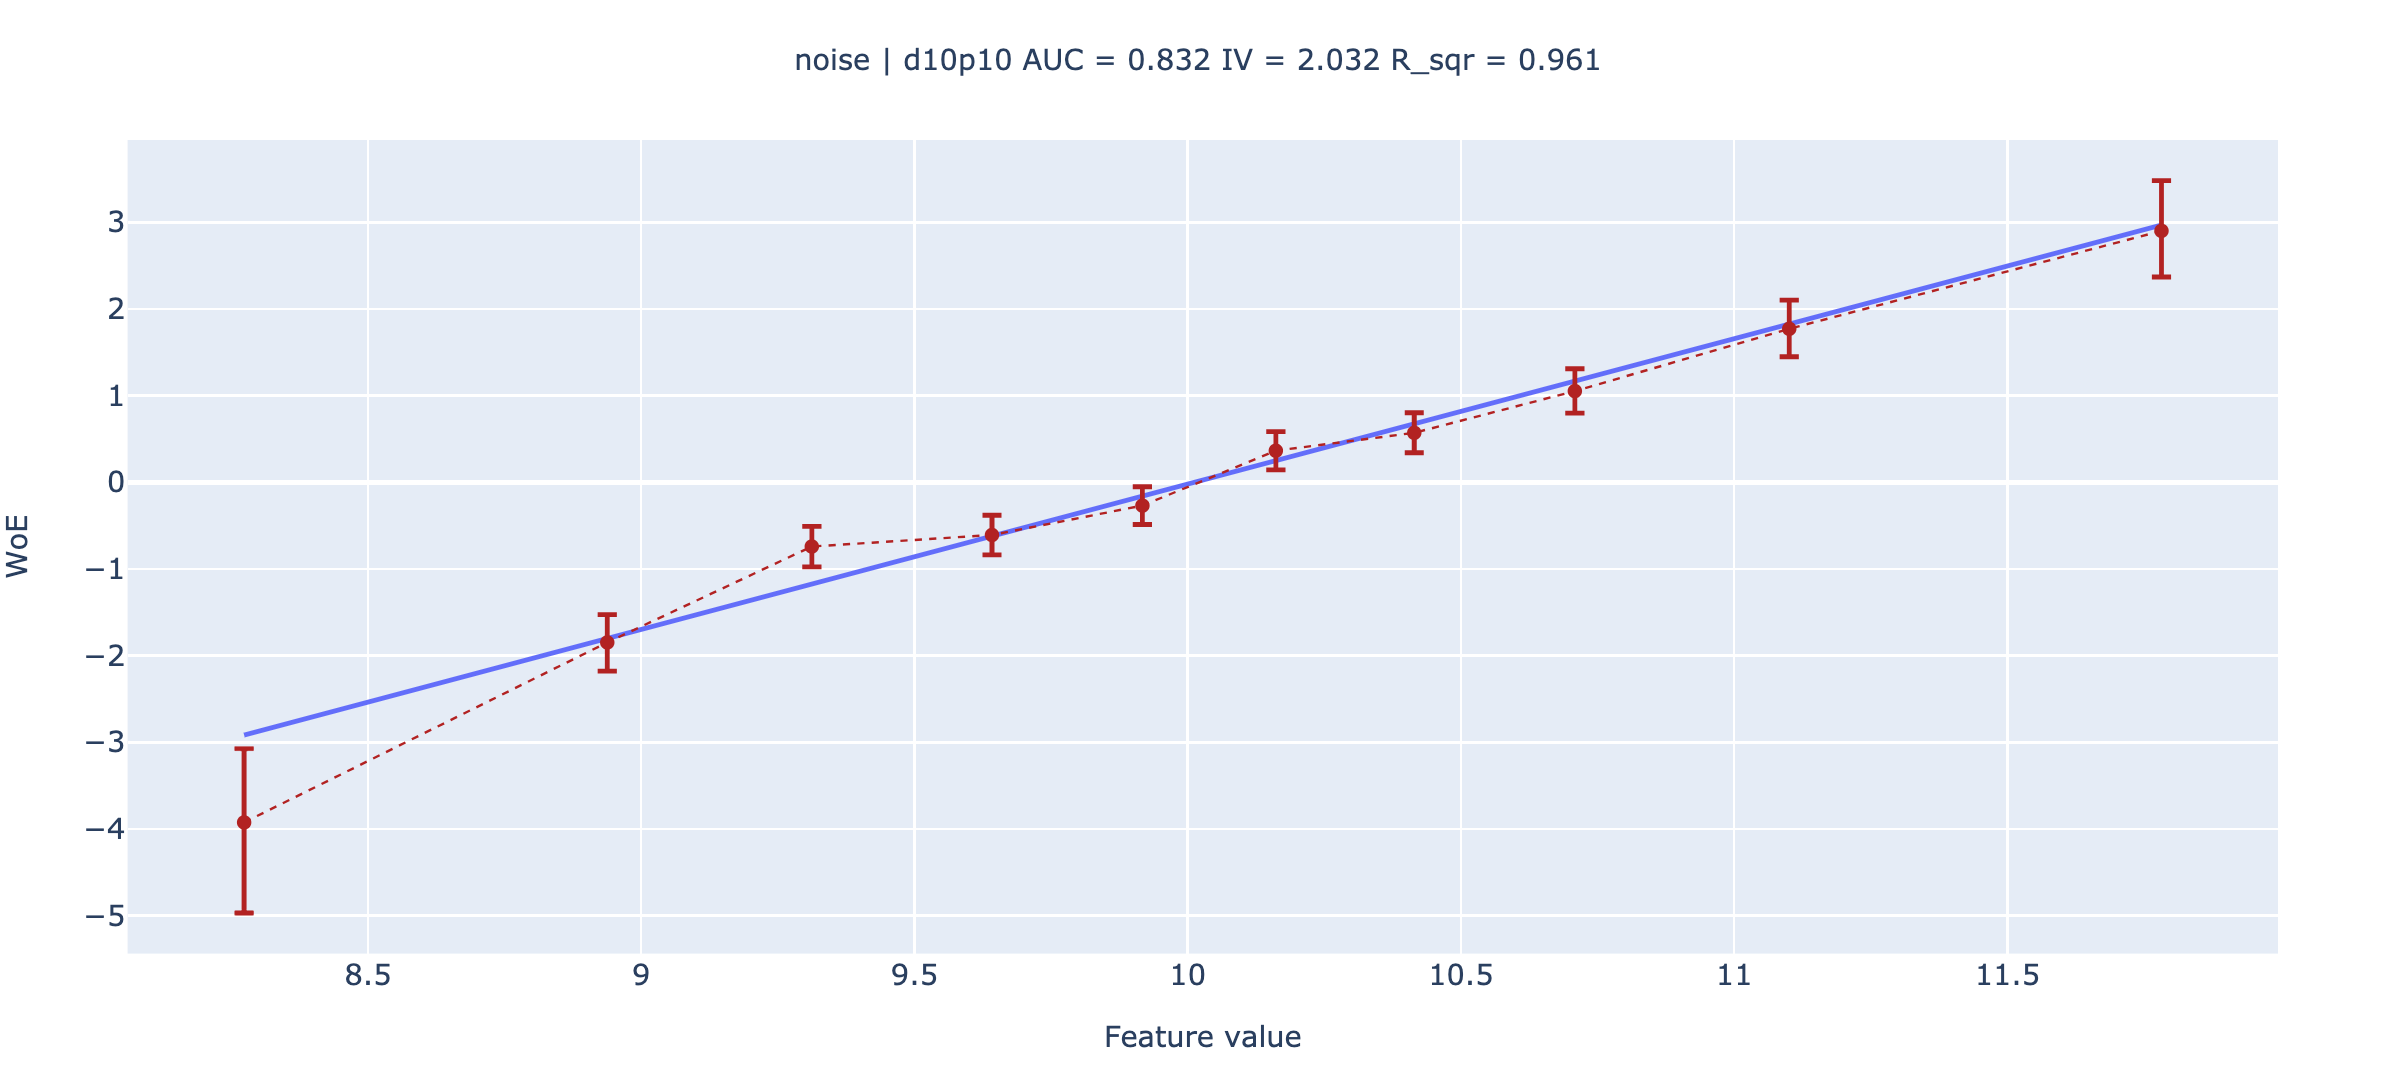

Нам нужно обратить внимание на 3 вещи:

**1. Фиолетовые точки с доверительными интервалами.**

Это WoE для каждого отдельного бакета. В идеале нам бы хотелось, чтобы **через эти точки можно было провести прямую линию** с небольшой погрешностью. Это и означает линейную взаимосвязь с таргетом.

**2. Синяя линия**

Попытка провести прямую линию через точки. Строится с помощью логистической регрессии на одной переменной. Затем предсказания переводятся в пространство WoE, отчего и получается прямая линия.

**3. Метрики в заголовке графика**

Метрики для признака:
 - roc auc, IV измеряют разделяющую способность переменной
 - $R^2$ измеряет *линейность взаимосвязи*. Признак считается линейным, если $R^2 \geq 0.95$

Далее напишем код для woe-line.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sps
from typing import Union, Tuple

## Шаг 0: разбиение на бакеты

In [2]:
def calc_buckets(x : Union[np.ndarray, pd.Series], n_buckets : int) -> np.ndarray:
    """Разбивает массив значений признака x на 
    n_buckets бакетов"""

    x = pd.Series(x).reset_index(drop=True)
    buckets = x.rank(method="dense", pct=True) * n_buckets
    buckets = np.ceil(buckets) - 1   # np.floor дает другой результат для 5.0, 6.0 и т.д.
    buckets = np.array(buckets, dtype=np.int16)

    return buckets

In [3]:
# протестируем calc_buckets
x = np.random.random(50)
print(x)
buckets = calc_buckets(x, 15)
buckets

[0.91029345 0.09271135 0.87654091 0.60672448 0.25513306 0.81778678
 0.70425266 0.78040788 0.20465099 0.99317126 0.55519681 0.17307288
 0.96947418 0.50247333 0.9127431  0.49407462 0.80904818 0.74343962
 0.81782305 0.83441473 0.06605476 0.3507413  0.51455923 0.26645896
 0.76444925 0.05521365 0.88310823 0.76720408 0.97419174 0.28810674
 0.65724214 0.46793477 0.79277657 0.56105477 0.62135808 0.46611717
 0.02790256 0.24152826 0.24436421 0.55782546 0.97216538 0.50644484
 0.27559923 0.62523507 0.34467082 0.29367078 0.4142936  0.82408803
 0.63879537 0.02560682]


array([13,  1, 12,  8,  2, 11,  9, 10,  2, 14,  7,  1, 14,  6, 13,  5, 11,
        9, 11, 12,  1,  4,  6,  3, 10,  0, 13, 10, 14,  3,  9,  5, 11,  7,
        8,  5,  0,  2,  2,  7, 14,  6,  3,  8,  4,  4,  5, 12,  8,  0],
      dtype=int16)

In [4]:
np.unique(buckets, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=int16),
 array([3, 3, 4, 3, 3, 4, 3, 3, 4, 3, 3, 4, 3, 3, 4], dtype=int64))

## Шаг 1: расчет WoE по бакетам

Пусть $x_i \in \{ 0, 1\}^n$

$x_i$ - это вектор, состоящий из значений таргета *в одном бакете* $i$. 

Для бакета можно посчитать количество единиц $B_i$ (bads, выпавшие в дефолт) и количество нулей $G_i$ (goods).

$$
B_i = \sum_{j \in x_i} \mathbb{I} \{ j = 1\}\quad G_i = \sum_{j \in x_i} \mathbb{I} \{ j = 0\}
$$

Также число бэдов и гудов можно посчитать и **для всей выборки**: 

$$
% X = x_1 \cup x_2 \ldots \cup x_n
X = \{x_1,\; x_2\; \ldots\; x_n\}
$$

$$
B = \sum_{j \in X} \mathbb{I} \{ j = 1\}\quad G = \sum_{j \in X} \mathbb{I} \{ j = 0\}
$$

Тогда WoE можно посчитать как

$$
\text{WoE}_i(x) = \ln \Big ( \frac{B_i}{G_i} \Big ) - \ln \Big ( \frac{B}{G} \Big ) 
$$

Преобразуем (в конце ноутбука док-во), и получим:

$$
\text{WoE}_i(x) = \text{logit}(b_i) - \text{logit}(b)\quad  (1)
$$

где 

$$
b = \frac{B}{B + G}\quad \text{logit}(p) = \ln \Big (  \frac{p}{1 - p} \Big )
$$

В дальнейшем будем считать WoE по формуле $(1)$

In [5]:
from scipy.special import logit

def woe_transform(badrate : float, offset : float) -> float:
    """Считаем WoE для бакета с данным badrate и выборки
    с данным offset."""
    woe = logit(badrate) - offset
    return woe

In [6]:
# протестируем woe_transform
print(f'woe(p>1) = {woe_transform(10, 0.2)}')
print(f'woe(p<0) = {woe_transform(-10, 0.2)}')
print(f'woe(p=0) = {woe_transform(0, 0.2)}')
print(f'woe(p=1) = {woe_transform(1, 0.9)}')
print(f'woe(p=0.2) = {woe_transform(0.2, 0.2)}')

woe(p>1) = nan
woe(p<0) = nan
woe(p=0) = -inf
woe(p=1) = inf
woe(p=0.2) = -1.5862943611198905


In [7]:
woe_transform(0.999, 0.75)

6.156754778648553

In [8]:
woe_transform(0.001, 0.1)

-7.006754778648554

Будем считать доверительный интервал к нашим вычислениям. 

Для того, чтобы построить доверительный интервал к $WoE$, можно сначала построить его для величины  $b_i = \frac{B_i}{B_i+G_i}$, а потом применить ```woe_transform```. В свою очередь величина $b_i$ является параметром распределения Бернулли, который мы можем оценить классическими методами.

In [9]:
from scipy import stats

def calculate_badrate(target : np.ndarray, buckets : np.ndarray, p:float = 0.95):
    unique_buckets = np.unique(buckets)
    result = []
    res_lower = []
    res_upper = []
    
    for bucket in unique_buckets:
        mask = (buckets == bucket)
        bad = np.sum(target[mask])
        capacity = np.sum(mask)  # not 0
        badrate = bad / capacity
        result.append(badrate)
        
        mean = np.mean(target[mask])
        std = np.std(target[mask])
        se = std/(capacity)**0.5
        alpha = (1-p)/2
        sigma = stats.norm().isf(alpha)
        lower, upper = mean - sigma*se, mean + sigma*se
        res_lower.append(lower)
        res_upper.append(upper)

    result = np.array(result)
    res_lower = np.array(res_lower)
    res_upper = np.array(res_upper)

    result[result == 0] = 0.001
    result[result == 1] = 0.999

    res_lower[res_lower <= 0] = 0.001
    res_lower[res_lower >= 1] = 0.999

    res_upper[res_upper <= 0] = 0.001
    res_upper[res_upper >= 1] = 0.999
    
    return result, res_lower, res_upper

In [10]:
target = np.array([0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0])
buckets = np.array([1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 4])
calculate_badrate(target, buckets)

(array([0.33333333, 0.66666667, 0.999     , 0.001     ]),
 array([0.001     , 0.13323204, 0.999     , 0.001     ]),
 array([0.86676796, 0.999     , 0.999     , 0.001     ]))

In [11]:
def woe_ci(target : np.ndarray, buckets : np.ndarray, offset : float) -> Tuple[pd.Series]:
    """Для каждого бакета вычисляем WoE и доверительный
    интервал для него."""
    # считаем бэдрейт и доверительный интервал для него (любым способом)
    
    badrate, badrate_lower, badrate_upper = calculate_badrate(target, buckets)
    
    # переходим от бэдрейта к woe
    woe, woe_lower, woe_upper = woe_transform(badrate, offset), woe_transform(badrate_lower, offset), woe_transform(badrate_upper, offset)
    
    return woe, woe_lower, woe_upper

In [12]:
target = np.array([0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0])
buckets = np.array([1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 4])
woe_ci(target, buckets, logit(sum(target) / len(target)))

(array([-0.51082562,  0.87546874,  7.08907634, -6.72443322]),
 array([-6.72443322, -1.69035751,  7.08907634, -6.72443322]),
 array([ 2.05500063,  7.08907634,  7.08907634, -6.72443322]))

## Шаг 2: расчет линейной интерполяции

In [13]:
from sklearn.linear_model import LogisticRegression

def calc_line(values : np.ndarray, target : np.ndarray, mean_feature : np.ndarray, offset : float) -> np.ndarray:
    """Строим линейную интерполяцию для WoE."""

    # строим логистическую регрессию на одном признаке
    # и считаем ее предсказания в точках – mean_feature
    values = values.reshape((values.shape[0], 1))
    mean_feature = mean_feature.reshape((mean_feature.shape[0], 1))
    clf = LogisticRegression().fit(values, target)
    proba = clf.predict_proba(mean_feature)[:,1]
    line = woe_transform(proba, offset)
    return line

In [14]:
# протестируем calc_line
values = np.array([-4, 0.1, 4])
target = np.array([1, 0, 0])
mean_feature = np.array([-5, 5])
offset = logit(sum(target) / len(target))

calc_line(values, target, mean_feature, offset)

array([ 2.99404046, -4.66508581])

## Шаг3: собираем результаты по бакетам в один словарь

In [15]:
def calc_buckets_info(values : np.ndarray, target : np.ndarray, buckets : np.ndarray) -> dict:
    """Для каждого бакета расчитывает
     - среднее значение признака
     - линейную интерполяцию в пространстве woe
     - значение woe и доверительный интервал для него"""
    
    buckets_info = {
        "mean_feature" : [],
        "line"         : [],
        "woe"          : [],
        "woe_lower"    : [],
        "woe_upper"    : []
    }
    offset = logit(sum(target) / len(target))
    woe, woe_lower, woe_upper = woe_ci(target, buckets, offset)
    buckets_info["woe"] = woe
    buckets_info["woe_lower"] = woe_lower
    buckets_info["woe_upper"] = woe_upper
    
    unique_buckets = np.unique(buckets)
    for bucket in unique_buckets:
        mask = (buckets == bucket)
        mean = np.mean(values[mask])
        buckets_info["mean_feature"].append(mean)
    buckets_info["line"] = calc_line(values, target, np.array(buckets_info["mean_feature"]), offset)
    
    return buckets_info

In [16]:
values = np.array([-1, 0.1, 0.2, 2.1, 5])
target = np.array([1, 0, 1, 0, 0])
buckets = np.array([1, 1, 2, 2, 2])

In [17]:
calculate_badrate(target, buckets)

(array([0.5       , 0.33333333]),
 array([0.001, 0.001]),
 array([0.999     , 0.86676796]))

In [18]:
# протестируем calc_buckets_info
calc_buckets_info(values, target, buckets)

{'mean_feature': [-0.45, 2.4333333333333336],
 'line': array([ 0.96628712, -1.25545293]),
 'woe': array([ 0.40546511, -0.28768207]),
 'woe_lower': array([-6.50128967, -6.50128967]),
 'woe_upper': array([7.31221989, 2.27814418])}

## Шаг 4: считаем метрики признака

Рассчитаем также несколько метрик, чтобы судить о качестве признака не только по картинкам. 

Приведем формулу для IV:

$$
\text{IV}(x) = \sum_{i = 1}^{n}\Big ( \frac{B_i}{B} - \frac{G_i}{G} \Big ) \times \text{WoE}_i
$$


IV имеет способность отслеживать моменты, когда признак хорошо делит таргет, при том что плохо ранжирует наблюдения. Auc в таких случаях будет показывать "средненький" результат.

In [19]:
from sklearn.metrics import roc_auc_score, r2_score

def calc_plot_title(
        values : np.ndarray,
        target : np.ndarray,
        buckets : np.ndarray
    ) -> str:
    """Считает для признака roc auc, IV, R^2"""

    unique_buckets, cap_b = np.unique(buckets, return_counts=True)
    offset = logit(sum(target) / len(target))

    # формула выше
    auc = 0
    IV = 0
    B = np.sum(target)
    G = len(target) - B

    mean_b = []
    woe_b = []
    
    for bucket in unique_buckets:
        mask = (buckets == bucket)
        capacity = np.sum(mask)  # not 0
        bad = np.sum(target[mask])
        badrate = bad / capacity
        woe = woe_transform(badrate, offset)
        
        mean_b.append(np.mean(values[mask]))
        woe_b.append(woe)
        
        IV += (bad/B - (len(target[mask]) - bad)/G) * woe
        
    auc = roc_auc_score(target, values)
    
    R_sqr = r2_score(woe_b, calc_line(values, target, np.array(mean_b), offset), sample_weight=cap_b)

    plot_title = (        
        f"AUC = {auc:.3f} "
        f"IV = {IV:.3f} "
        f"R_sqr = {R_sqr:.3f} "
    )

    return plot_title

In [21]:
roc_auc_score([0, 0, 1, 0, 1, 1], [5, 4, 0.1, 3, 2, 1])

0.0

## Шаг 5: собираем все в одну функцию и строим график

In [22]:
import plotly.graph_objects as go

def make_figure(buckets_info : dict, plot_title : str) -> go.Figure:
    """Строит график линейности."""
    fig = go.Figure()

    # общие настройки
    title = dict(
        text=plot_title,
        y=0.95,
        x=0.5,
        font=dict(size=12),
        xanchor="center",
        yanchor="top"
    )
    margin = go.layout.Margin(
        l=50,
        r=50,
        b=50,
        t=60
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["line"],
            mode='lines',
            name="interpolation_line",
            showlegend=False
        )
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["woe"],
            line=dict(
                color='firebrick',
                width=1,
                dash='dot'
            ),
            error_y=dict(
                type='data',
                symmetric=False,
                array=buckets_info["woe_upper"],
                arrayminus=buckets_info["woe_lower"]
            ),
            name="WoE",
            showlegend=False)
    )

    fig.update_layout(
        width=1000,
        height=450,
        xaxis_title=dict(
            text='Feature value',
            font=dict(size=12)
        ),
        yaxis_title=dict(
            text="WoE",
            font=dict(size=12)
        ),
        title=title,
        margin=margin
    )

    return fig

In [23]:
def woe_line(
        values : np.ndarray,
        target : np.ndarray,
        n_buckets : int
    ) -> go.Figure:
    """График линейности переменной по WoE."""
    buckets : np.ndarray = calc_buckets(values, n_buckets)
    buckets_info : pd.DataFrame = calc_buckets_info(values, target, buckets)
    plot_title : str = calc_plot_title(values, target, buckets)
    fig = make_figure(buckets_info, plot_title)
    return fig

Чтобы протестировать реализацию, сгенерируем синтетические данные:

In [24]:
sample_size = int(1e4)
noise_std = 1

df = pd.DataFrame()
y = np.array(sample_size // 2 * [0] + sample_size // 2 * [1])
df['target']  = y

np.random.seed(89)
x = np.concatenate([sps.norm(0, noise_std).rvs(size = sample_size // 2), sps.norm(1, noise_std).rvs(size = sample_size // 2)])
df['feature'] = x

D:\python\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\python\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='feature', ylabel='Count'>

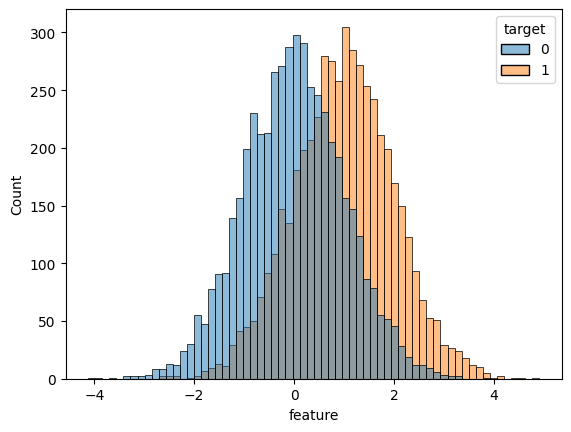

In [25]:
sns.histplot(df, x = 'feature', hue = 'target')

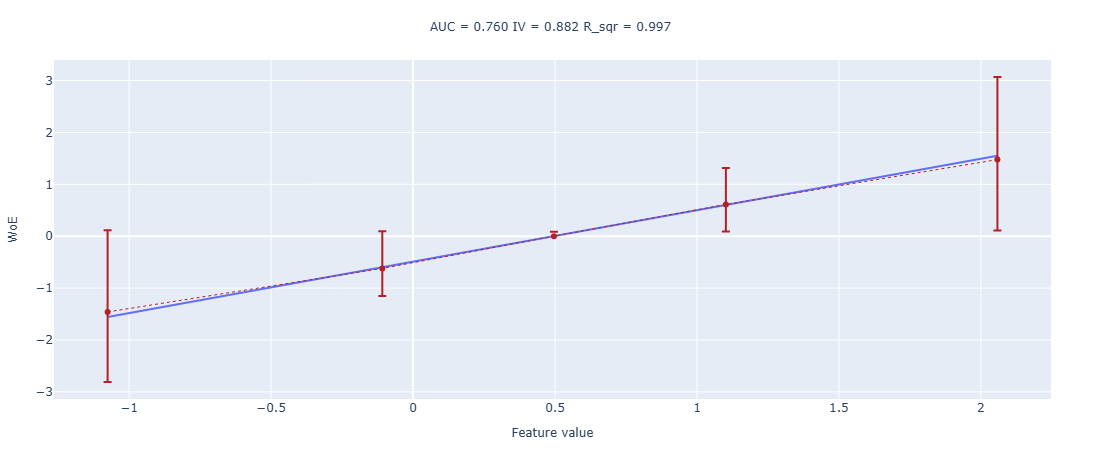

In [26]:
woe_line(values=x, target=y, n_buckets=5)

## Эксперименты

### №1

Как будут меняться график, метрики разделяющей способности и $R^2$ при изменении дисперсии шума (параметр `noise_std`)?

При уменьшении дисперсии, данные становятся заметно более разделимыми, поэтому соответственно растут метрики отделимости auс и IV.

И, соответственно, при ее увеличении данные сильнее пересекаются и их уже нельзя хорошо отделить. IV и auc падают.

### №2

Запустим функцию с `values=x ** 2`

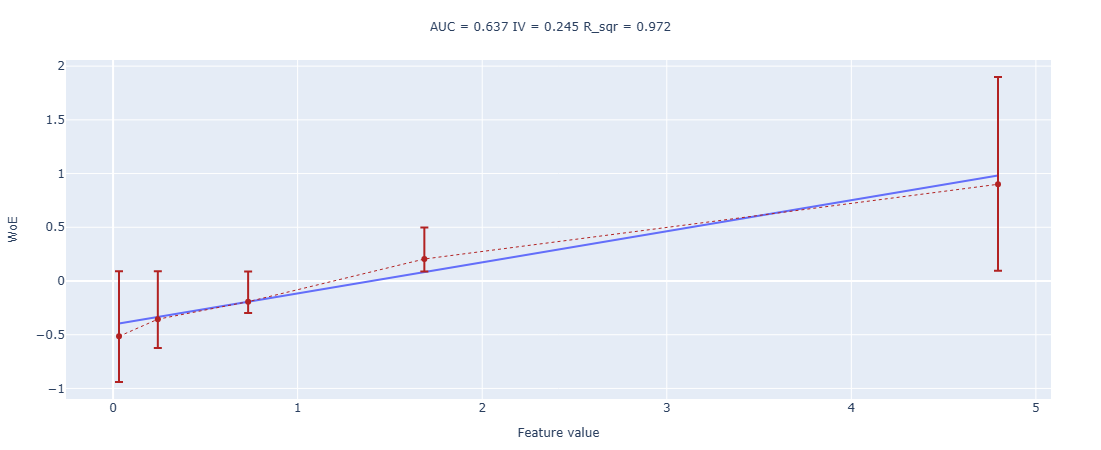

In [27]:
woe_line(values=x**2, target=y, n_buckets=5)

По графику видно, что линейность испортилась, потеряли знак, сместились бакеты.

Исправить это можно если преобразовать признак обратно через sqrt и сохранять знак.

### №3

Запустим функцию с `values=np.exp(x)`

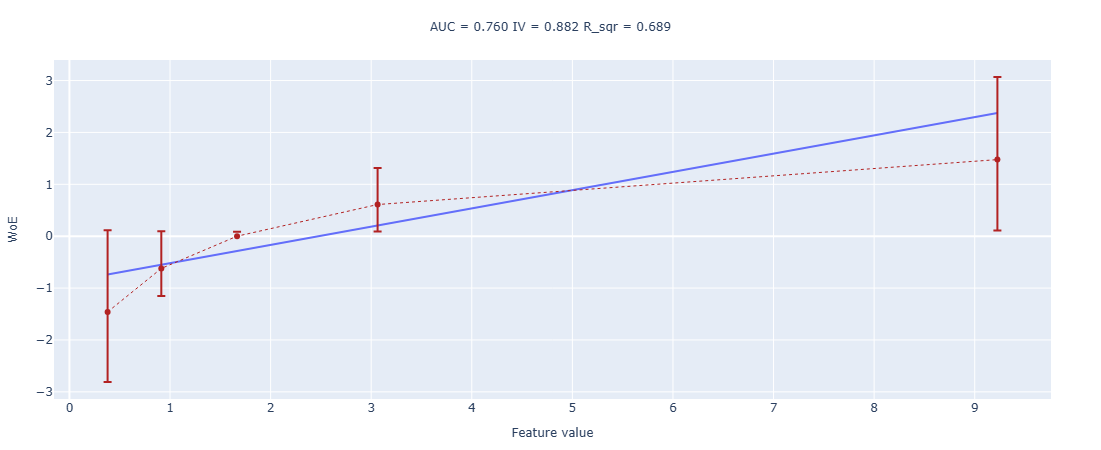

In [28]:
woe_line(values=np.e**x, target=y, n_buckets=5)

В этом случае линейность испортилась уже сильно, т.к. x^2 это о малое от e^x. Так же как и в предыдущем случае потеряли знак и сместились бакеты. 
Еще можно заметить, что woe-line построился в виде функции логарифма.

Исправляется логарифмированием с основанием e и сохранением знака.

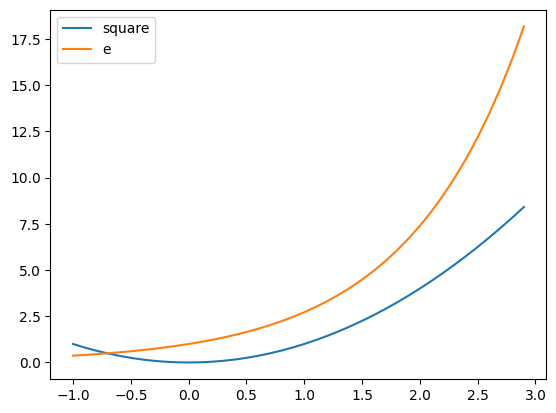

In [29]:
import matplotlib.pyplot as plt

x = np.arange(-10, 30)/10
plt.plot(x, x**2)
plt.plot(x, np.e**x)
plt.legend(['square', 'e'])

# Часть 2. Строим ЛогРег.

In [30]:
df = pd.read_csv('data/risks-24-hw1.csv', index_col=0)
df

feature_1  feature_2     feature_3  feature_4  feature_5  feature_6  \
0      -1.444709   3.554779      1.308371  -0.689329   0.366748   2.646755   
1       1.132531  -0.207661     -2.142882   0.000527   2.369319   8.712916   
2       1.268781  -0.243999  10000.000000   0.000683   0.100580   2.137392   
3      -1.278475  -2.579890      5.050763  -0.371907   0.523984   2.612065   
4       3.507807   0.152661     -8.905005   0.939313   1.092974   4.224315   
...          ...        ...           ...        ...        ...        ...   
99995  -3.061422  -0.163832      4.812768  -0.417794   0.182394  -0.582374   
99996   0.222451  -0.273191      0.380895   0.002889   3.724334   1.007479   
99997   1.078498   0.339526     -5.184847   0.234131   0.544720  -3.320917   
99998  -1.431421  -0.605388      2.466023  -0.009963   0.308079   6.889658   
99999   0.435883  -0.336180     -4.599904   0.051063   0.099353   1.267455   

       feature_7  feature_8  feature_9  feature_10  feature_11  feature_12  \
0              1   8.825418   2.646755   11.565953 -513.014565   -1.072893   
1              1   3.453220   8.712916    4.935665  -39.351891    3.409855   
2              1 -10.116061   2.137392    6.234414   -4.993050    3.121126   
3              1   6.780814   2.612065    2.682539 -509.273095   -1.242741   
4              1 -10.638134   4.224315    6.881602   -2.034797    2.814972   
...          ...        ...        ...         ...         ...         ...   
99995          0  -9.959913  -0.582374    5.294558 -524.265291   -1.648415   
99996          1  -1.645952   1.007479    5.571499  -13.499956    3.386865   
99997          1  -5.565932  -3.320917   -0.433263    3.928387    3.290285   
99998          0  -4.517188   6.889658   10.812813 -507.593408   -1.398568   
99999          1  -4.782919   1.267455    3.534312  -11.032778    3.293867   

        feature_13  feature_14 feature_15  d4p12  
0         7.936545    0.047069          B      1  
1        17.015210    0.029288          A      0  
2         4.878602    0.237255          A      0  
3        20.293025    0.907788          B      0  
4         7.352399    0.276854          A      0  
...            ...         ...        ...    ...  
99995     5.410059    0.855190          B      0  
99996    92.903615    0.006668          A      1  
99997     1.233853    0.160933          A      1  
99998  1904.246147    0.077164          B      1  
99999   142.502312    0.002221          A      1  

[100000 rows x 16 columns]

```feature_1, ..., feature_14``` - числа 
```feature_15``` - категориальная фича

## EDA.

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   feature_1   100000 non-null  float64
 1   feature_2   100000 non-null  float64
 2   feature_3   100000 non-null  float64
 3   feature_4   100000 non-null  float64
 4   feature_5   100000 non-null  float64
 5   feature_6   100000 non-null  float64
 6   feature_7   100000 non-null  int64  
 7   feature_8   100000 non-null  float64
 8   feature_9   100000 non-null  float64
 9   feature_10  100000 non-null  float64
 10  feature_11  100000 non-null  float64
 11  feature_12  100000 non-null  float64
 12  feature_13  100000 non-null  float64
 13  feature_14  100000 non-null  float64
 14  feature_15  100000 non-null  object 
 15  d4p12       100000 non-null  int64  
dtypes: float64(13), int64(2), object(1)
memory usage: 13.0+ MB


In [32]:
df.describe()

feature_1      feature_2      feature_3     feature_4  \
count  100000.000000  100000.000000  100000.000000  1.000000e+05   
mean       -0.004065      -0.198827      -6.283870 -1.250730e-01   
std         2.625003     169.576125    2344.152317  5.939374e-01   
min       -54.598150  -38296.171946  -10000.000000 -1.999994e+00   
25%        -1.011666      -0.385200      -4.215224 -2.289926e-01   
50%        -0.058406      -0.072894       0.003200 -2.253828e-09   
75%         1.004057       0.395806       4.255211  1.127132e-01   
max        39.011329   20133.753873   10000.000000  9.999952e-01   

           feature_5      feature_6      feature_7      feature_8  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        1.003480       2.973727       0.901520      -2.514795   
std         1.004035       3.998071       0.297964       5.009291   
min         0.000002     -16.569150       0.000000     -26.496544   
25%         0.288478       0.281313       1.000000      -5.893561   
50%         0.694669       2.971161       1.000000      -2.511154   
75%         1.389851       5.663969       1.000000       0.859395   
max        12.006909      19.874766       1.000000      19.258719   

           feature_9     feature_10     feature_11     feature_12  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        2.973727       3.640370    -256.924907       1.013153   
std         3.998071       4.977886     260.742462       2.314468   
min       -16.569150     -16.847030   -1012.820365      -9.210340   
25%         0.281313       0.270052    -506.548930      -1.262413   
50%         2.971161       3.669848    -282.922772      -0.800022   
75%         5.663969       6.984301      -0.080408       3.344923   
max        19.874766      24.764462     446.685530       3.951220   

         feature_13    feature_14          d4p12  
count  1.000000e+05  1.000000e+05  100000.000000  
mean   9.969348e+02  2.885691e-01       0.425370  
std    4.699415e+03  3.785086e-01       0.494401  
min    1.666947e-19  6.195140e-11       0.000000  
25%    3.451754e+00  1.371482e-03       0.000000  
50%    2.341854e+01  4.439380e-02       0.000000  
75%    1.536384e+02  6.085319e-01       1.000000  
max    3.729609e+05  1.000000e+00       1.000000

In [33]:
df['d4p12'].value_counts(normalize=True)

d4p12
0    0.57463
1    0.42537
Name: proportion, dtype: float64

In [34]:
df['feature_7'].value_counts()

feature_7
1    90152
0     9848
Name: count, dtype: int64

In [35]:
df['feature_15'].value_counts()

feature_15
B    50106
A    49894
Name: count, dtype: int64

D:\python\Lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

D:\python\Lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



<Axes: xlabel='feature_15', ylabel='Count'>

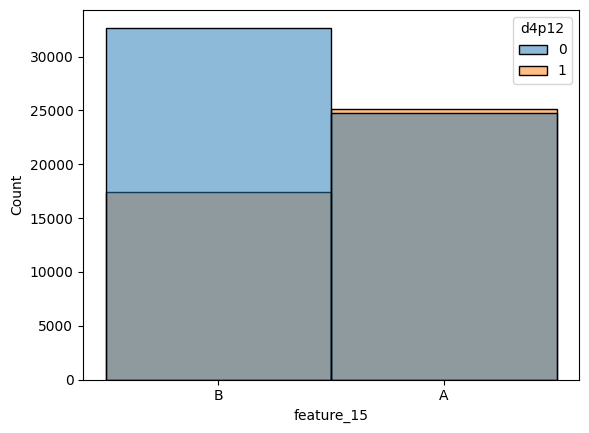

In [36]:
sns.histplot(data=df, x='feature_15', hue='d4p12')

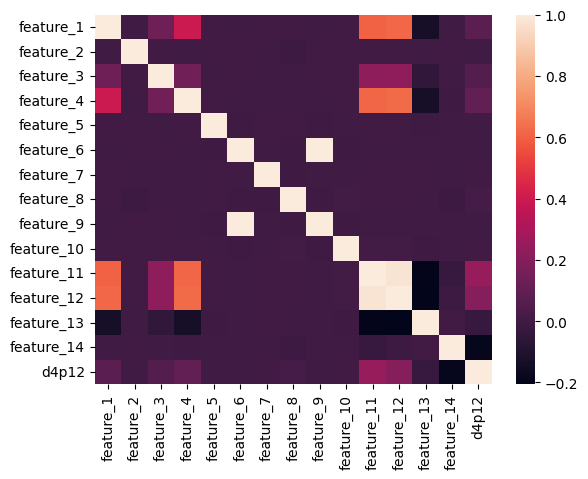

In [37]:
sns.heatmap(df.drop(['feature_15'], axis=1).corr(), annot=False)
plt.plot();

In [38]:
# sns.histplot(data=df, x='feature_9', hue='d4p12')
# plt.plot();

9 и 6 признак фактически одинаковы. Поэтому оставим один из них.

In [39]:
df.drop(['feature_6'], axis=1, inplace=True)

In [40]:
df[['feature_11', 'feature_12']].corr()

feature_11  feature_12
feature_11    1.000000    0.973277
feature_12    0.973277    1.000000

## Бейзлайн.

Попробуем построить ЛогРег только на числовых данных.

In [41]:
def calc_iv(
        values : np.ndarray,
        target : np.ndarray,
        buckets : np.ndarray
    ) -> str:

    unique_buckets = np.unique(buckets)
    offset = logit(sum(target) / len(target))

    IV = 0
    B = np.sum(target)
    G = len(target) - B
    
    for bucket in unique_buckets:
        mask = (buckets == bucket)
        capacity = np.sum(mask)  # not 0
        bad = np.sum(target[mask])
        badrate = bad / capacity
        woe = woe_transform(badrate, offset)
        
        IV += (bad/B - (len(target[mask]) - bad)/G) * woe

    return IV

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [43]:
d4p12 = df.d4p12
df = df.drop(['d4p12'], axis=1)

In [44]:
need_scale = list(set(df.columns) - {'feature_7', 'feature_15'})

In [45]:
scaled = StandardScaler().fit_transform(df[need_scale])
scaled = pd.DataFrame(scaled, columns=need_scale)
scaled['feature_7'] = df.feature_7

In [46]:
X_train, X_test, y_train, y_test = train_test_split(np.array(scaled), d4p12, test_size=0.2, random_state=0)

In [47]:
lr = LogisticRegression()

lr.fit(X_train, y_train)

LogisticRegression()

In [48]:
y_pred = lr.predict(X_test)
y_pred_train = lr.predict(X_train)

In [49]:
n = int(df.shape[0] ** (1/3) / 3)
n

15

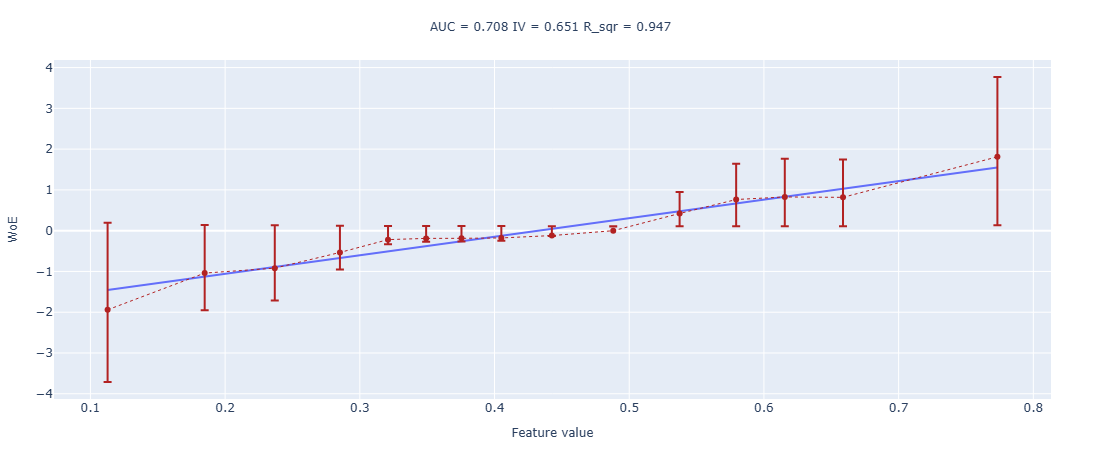

In [50]:
woe_line(values=lr.predict_proba(X_test)[:,1], target=y_test, n_buckets=n)

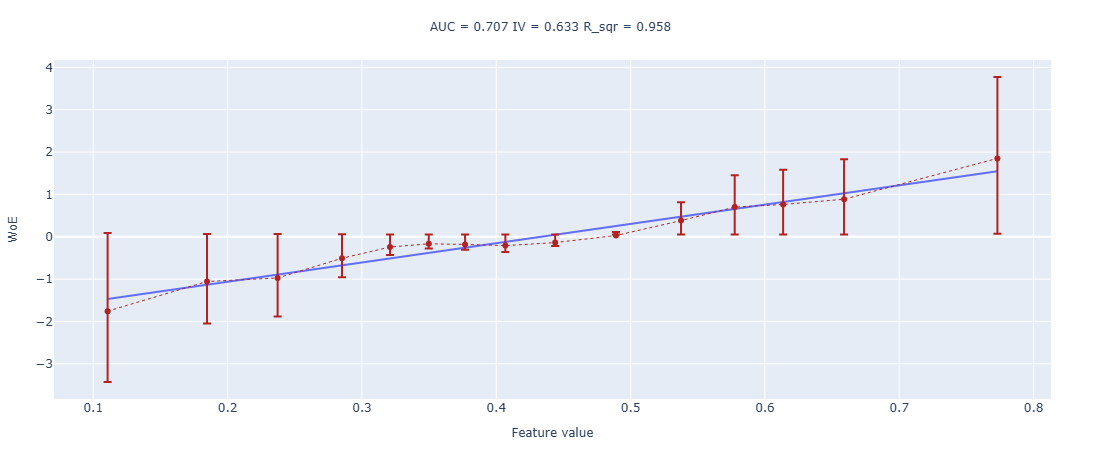

In [51]:
woe_line(values=lr.predict_proba(X_train)[:,1], target=y_train, n_buckets=n)

In [52]:
train_proba = lr.predict_proba(X_train)[:,1]
test_proba = lr.predict_proba(X_test)[:,1]

In [53]:
print(f'train auc: {roc_auc_score(y_train, train_proba)}')
print(f'test auc: {roc_auc_score(y_test, test_proba)}')

train auc: 0.7070618995847485
test auc: 0.7083735246452023


In [54]:
print(f'IV train: {calc_iv(train_proba, y_train, calc_buckets(train_proba, n))}')
print(f'IV test: {calc_iv(test_proba, y_test, calc_buckets(test_proba, n))}')

IV train: 0.6325766340031866
IV test: 0.6505722736314199


## Добавляем категориальную переменную.

In [55]:
df['feature_15'] = pd.get_dummies(df['feature_15'], columns = ['feature_15']).astype('int').A
scaled['feature_15'] = df['feature_15']

Оставляем только один столбец, т.к. иначе между ними будет корреляция, а один по смыслу он будет отражать то же самое.

<Axes: >

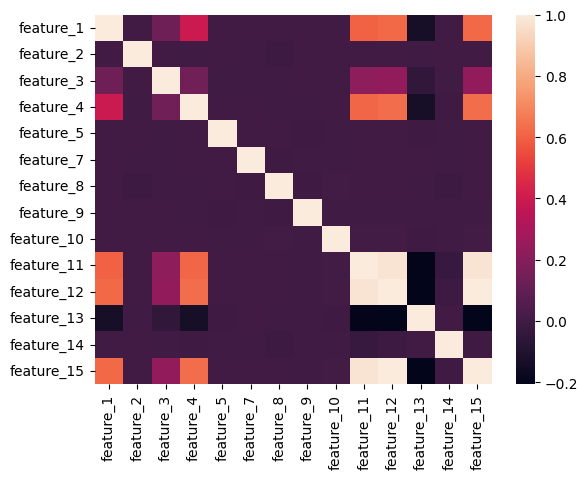

In [56]:
sns.heatmap(df.corr(), annot=False)

In [57]:
df[['feature_11', 'feature_12', 'feature_15']].corr()

feature_11  feature_12  feature_15
feature_11    1.000000    0.973277    0.972374
feature_12    0.973277    1.000000    0.995353
feature_15    0.972374    0.995353    1.000000

12 и 15 признаки имеют корреляцию, близкую к 1. Но на самом деле между ними нет линейной корреляции:

D:\python\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning:

The figure layout has changed to tight



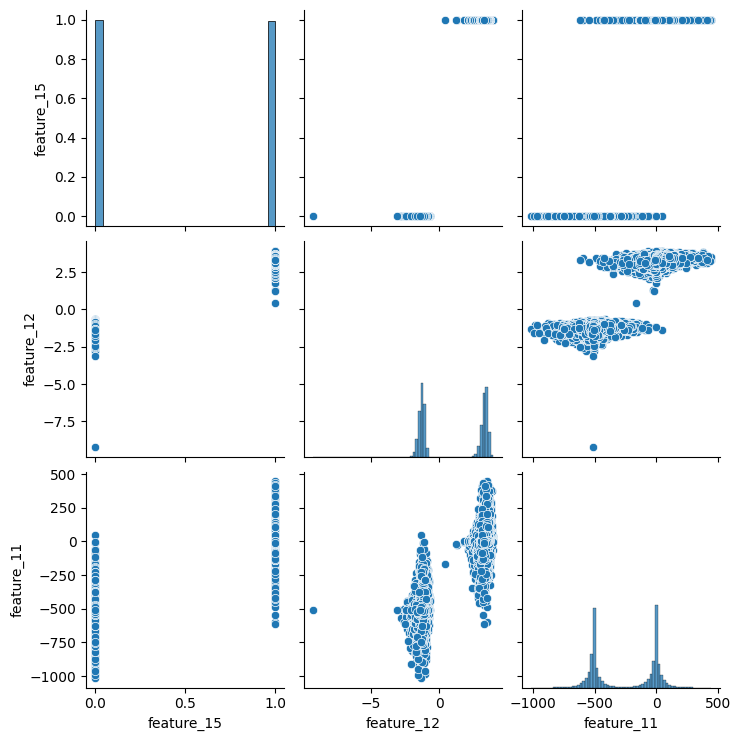

In [58]:
sns.pairplot(df[['feature_15', 'feature_12', 'feature_11']])

In [59]:
X_train, X_test, y_train, y_test = train_test_split(scaled, d4p12, test_size=0.2, random_state=0)

In [60]:
lr = LogisticRegression()

lr.fit(X_train, y_train)

LogisticRegression()

In [61]:
y_pred = lr.predict(X_test)
y_pred_train = lr.predict(X_train)

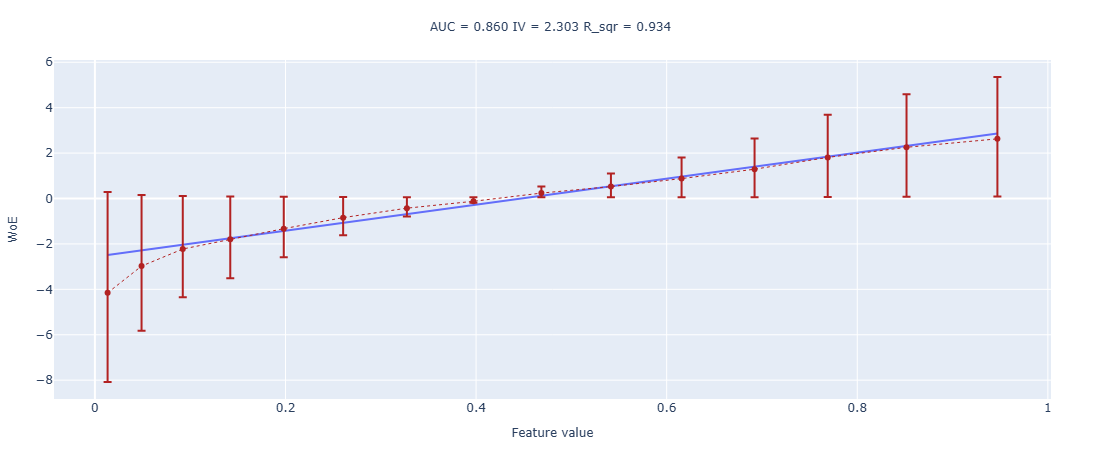

In [62]:
woe_line(values=lr.predict_proba(X_train)[:,1], target=y_train, n_buckets=n)

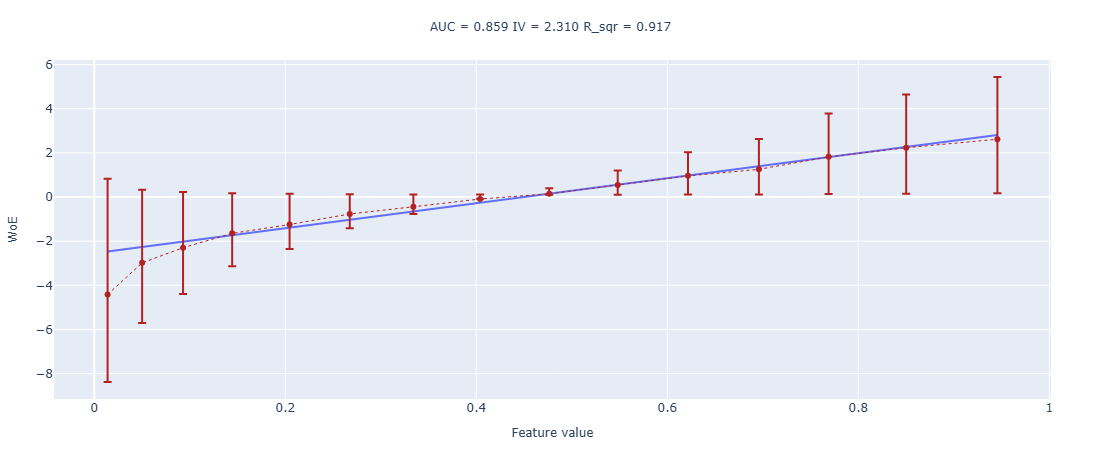

In [63]:
woe_line(values=lr.predict_proba(X_test)[:,1], target=y_test, n_buckets=n)

In [64]:
train_proba = lr.predict_proba(X_train)[:,1]
test_proba = lr.predict_proba(X_test)[:,1]

In [65]:
print(f'train auc: {roc_auc_score(y_train, train_proba)}')
print(f'test auc: {roc_auc_score(y_test, test_proba)}')

train auc: 0.860439568426595
test auc: 0.8585591413674654


In [66]:
print(f'IV train: {calc_iv(train_proba, y_train, calc_buckets(train_proba, n))}')
print(f'IV test: {calc_iv(test_proba, y_test, calc_buckets(test_proba, n))}')

IV train: 2.302531854805437
IV test: 2.30992035807521


Качество увеличилось.

## Линеаризация переменных.

На самом деле, категориальные переменные можно учитывать в моделях совсем по-другому. С их помощью можно выделить в модели сегменты. Каждому сегменту соответствует своя модель (в нашем случае логрег). 

Примером такой сегментации может стать сегментация по наличию кредитной истории. В этом случае на разных сегментах будут не просто отдельные модели, но и даже разный изначальный набор признаков. Другое свидетельство удачной сегментации – разный характер зависимости признаков и целевой переменной. Это можно увидеть на графике линейности признака по WoE. Этим мы и займемся далее.

Используем переменную 15 для сегментации модели. На каждом из двух сегментов линеаризуем переменные.

In [68]:
df['d4p12'] = d4p12
df0 = df[df.feature_15 == 0].drop(['feature_15'], axis=1)
df1 = df[df.feature_15 == 1].drop(['feature_15'], axis=1)

In [69]:
# def clip_outliers(df):
#     for column in (set(df.columns) - {'feature_7', 'feature_3'}):
#         mean = df[column].mean()
#         std = df[column].std()
#         lower_bound = mean - 3 * std
#         upper_bound = mean + 3 * std
#         df[column] = np.clip(df[column], lower_bound, upper_bound)
#     return df

# df0 = clip_outliers(df0)
# df1 = clip_outliers(df1)

In [70]:
# def drop_outliers(df):
#     f7 = df.feature_7.copy()  # категориальная фича
#     f3 = df.feature_3.copy()  # есть отдельная большая группа наблюдений, сильно отстоящая от основной массы
#     df = df.drop(['feature_7', 'feature_3'], axis=1)
#     df = df[~((df - df.mean()).abs() > 3 * df.std()).any(axis=1)]
#     df = df.join(f7)
#     df = df.join(f3)
#     return df

# df0 = drop_outliers(df0)
# df1 = drop_outliers(df1)

Чистка/обрезка выбросов не дала значимого улучшения результата, поэтому оставляю, как есть.

Чистка ~ -2%

Обрезка ~ +0.01%

### feature_1

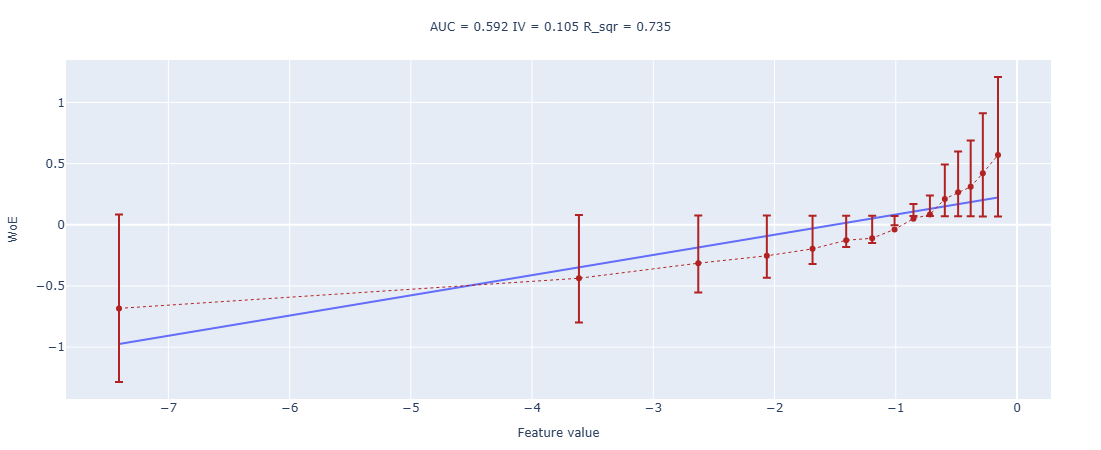

In [71]:
woe_line(values=np.array(df0.feature_1), target=df0.d4p12, n_buckets=n)

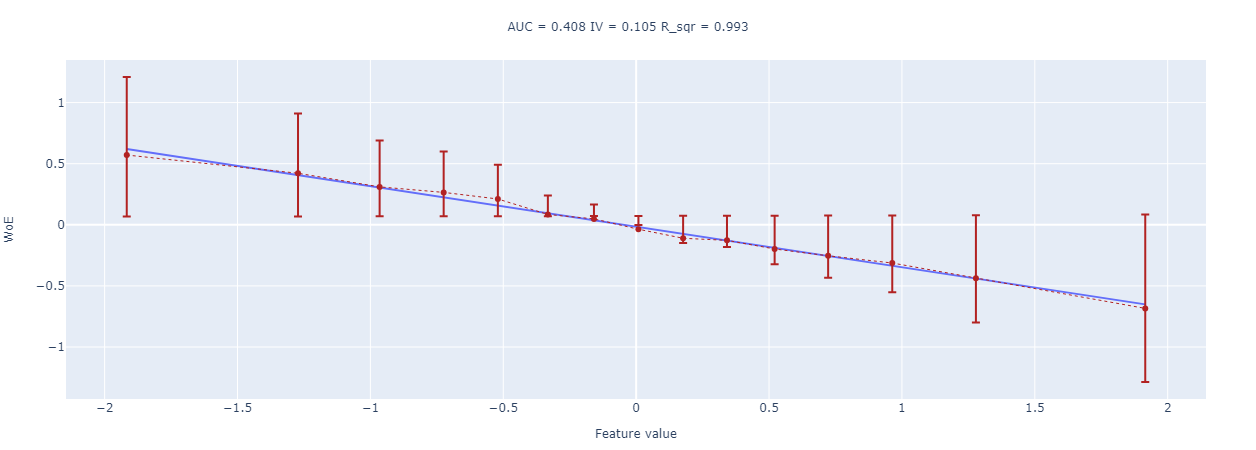

In [72]:
woe_line(values=np.array(-np.log(1/-df0.feature_1)), target=df0.d4p12, n_buckets=n)

In [73]:
df0.feature_1 = -np.log(1/-df0.feature_1)

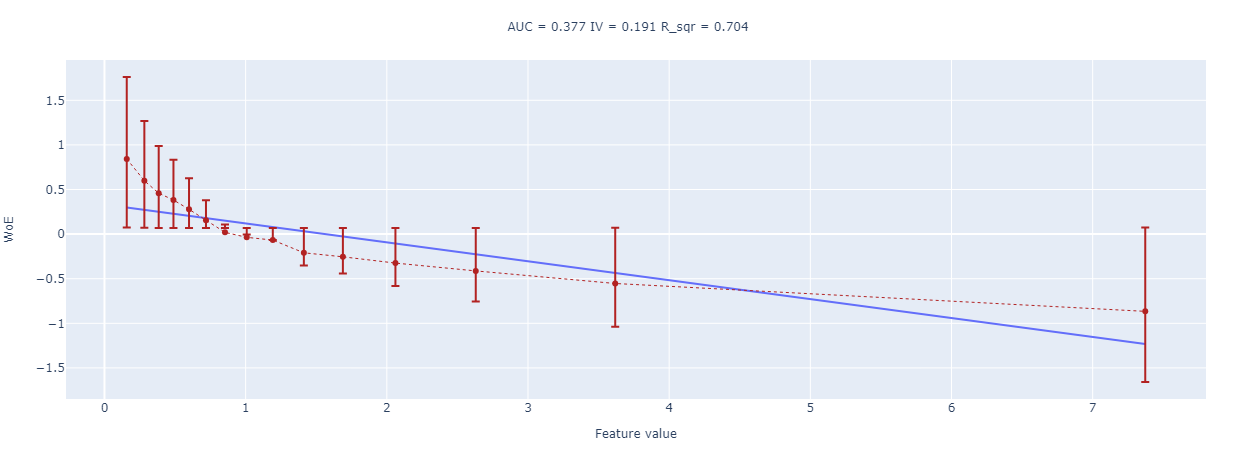

In [74]:
woe_line(values=np.array(df1.feature_1), target=df1.d4p12, n_buckets=n)

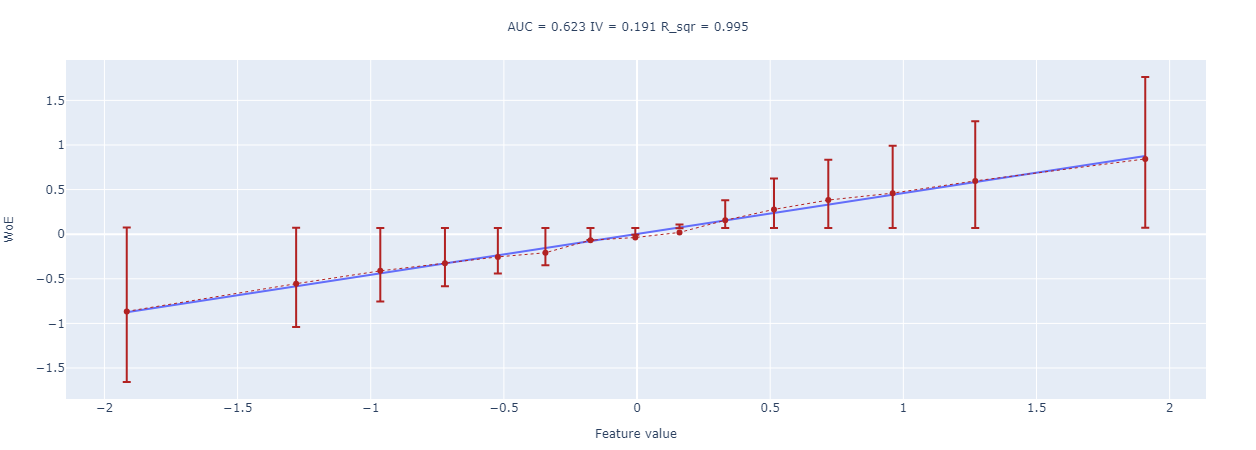

In [75]:
woe_line(values=np.array(np.log(1/df1.feature_1)), target=df1.d4p12, n_buckets=n)

In [76]:
df1.feature_1 = np.log(1/df1.feature_1)

### feature_2

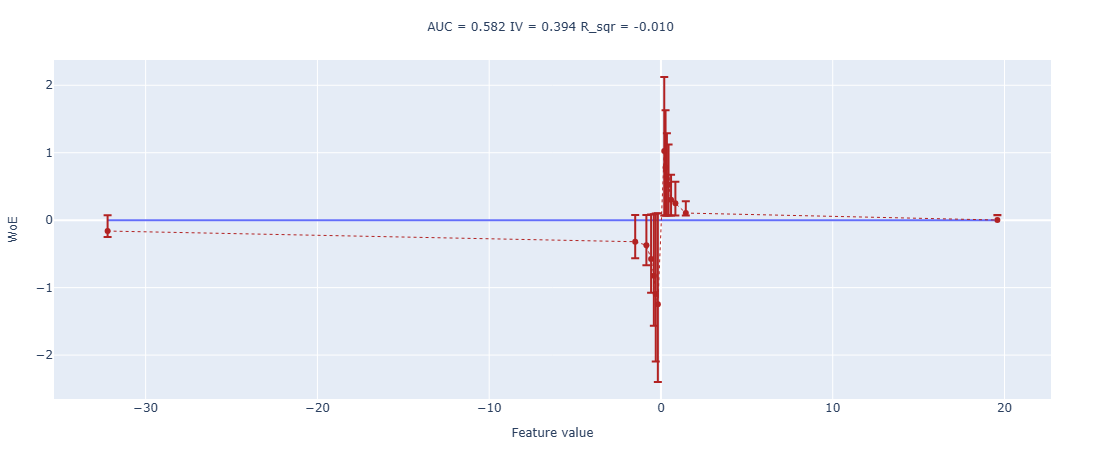

In [77]:
woe_line(values=np.array(df0.feature_2), target=df0.d4p12, n_buckets=n)

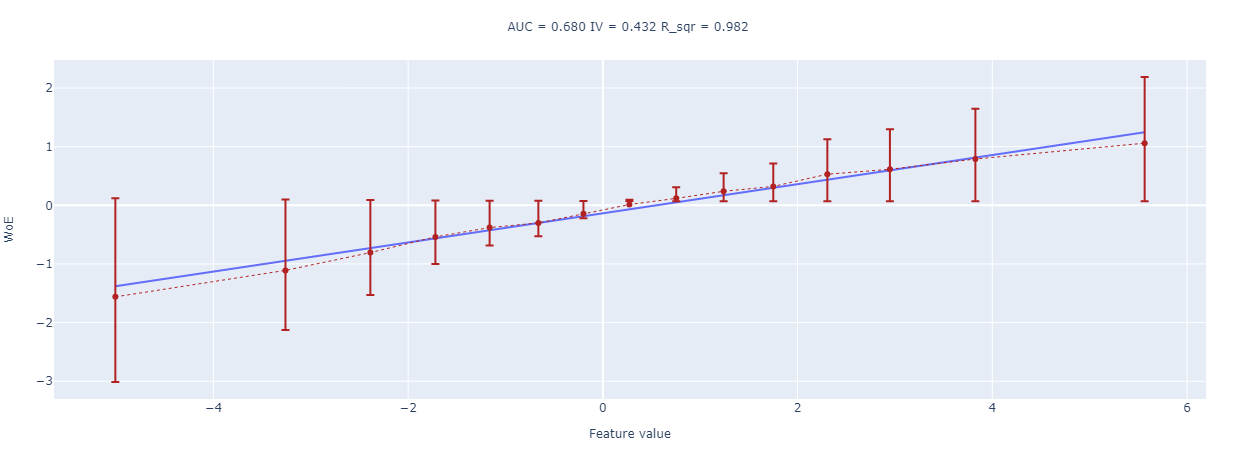

In [78]:
woe_line(values=np.array(1/df0.feature_2), target=df0.d4p12, n_buckets=n)

In [79]:
df0.feature_2 = 1/df0.feature_2

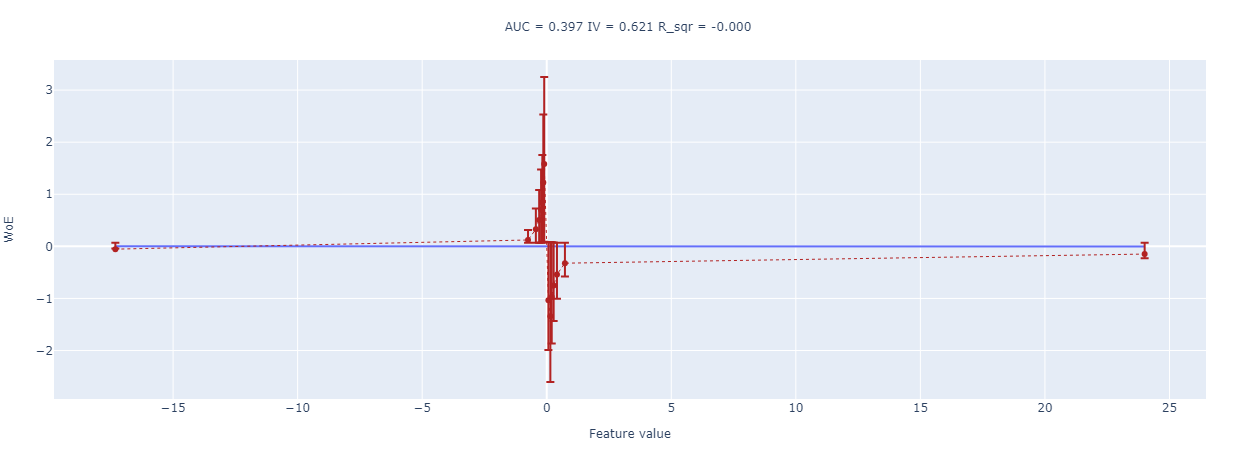

In [80]:
woe_line(values=np.array(df1.feature_2), target=df1.d4p12, n_buckets=n)

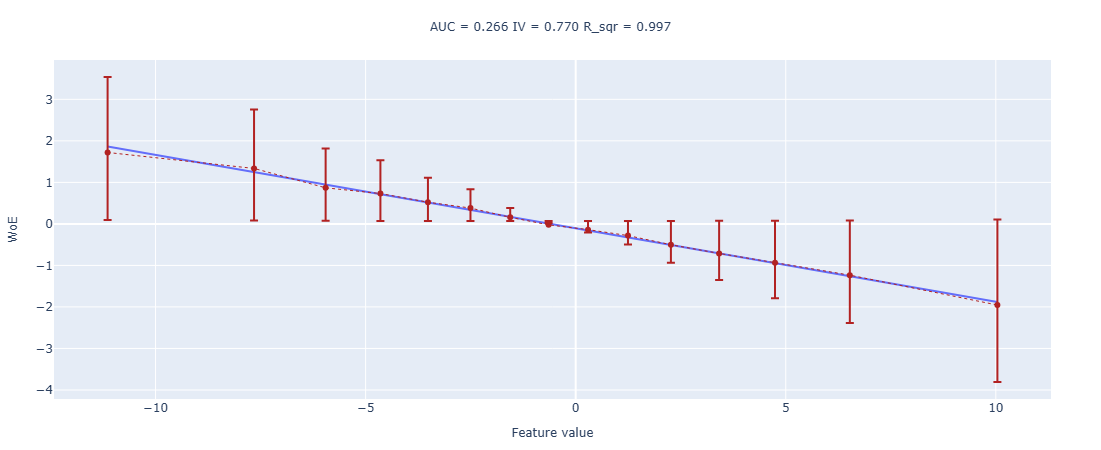

In [81]:
woe_line(values=np.array(1/df1.feature_2), target=df1.d4p12, n_buckets=n)

In [82]:
df1.feature_2 = 1/df1.feature_2

### feature_3

(<Axes: >, <Axes: >)

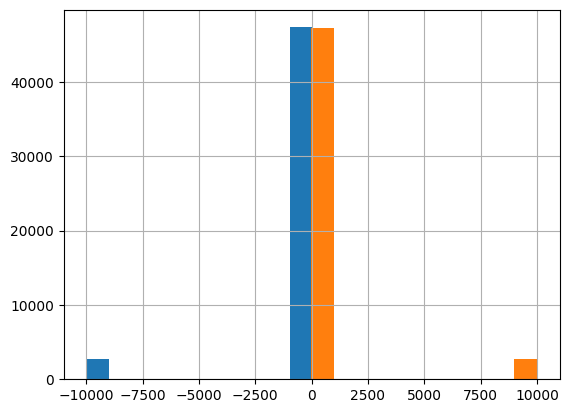

In [83]:
df0.feature_3.hist(), df1.feature_3.hist()

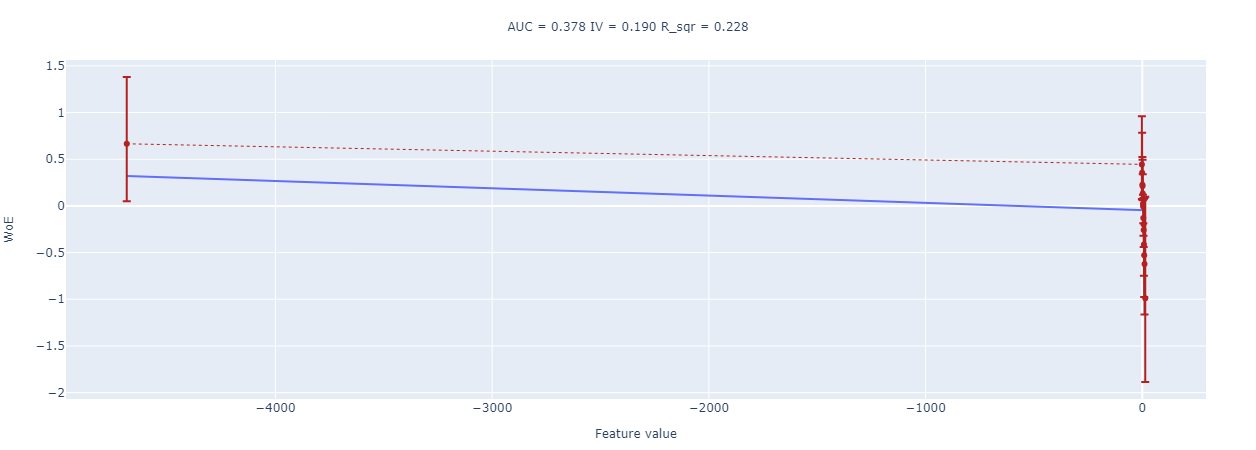

In [84]:
woe_line(values=np.array(df0.feature_3), target=df0.d4p12, n_buckets=n)

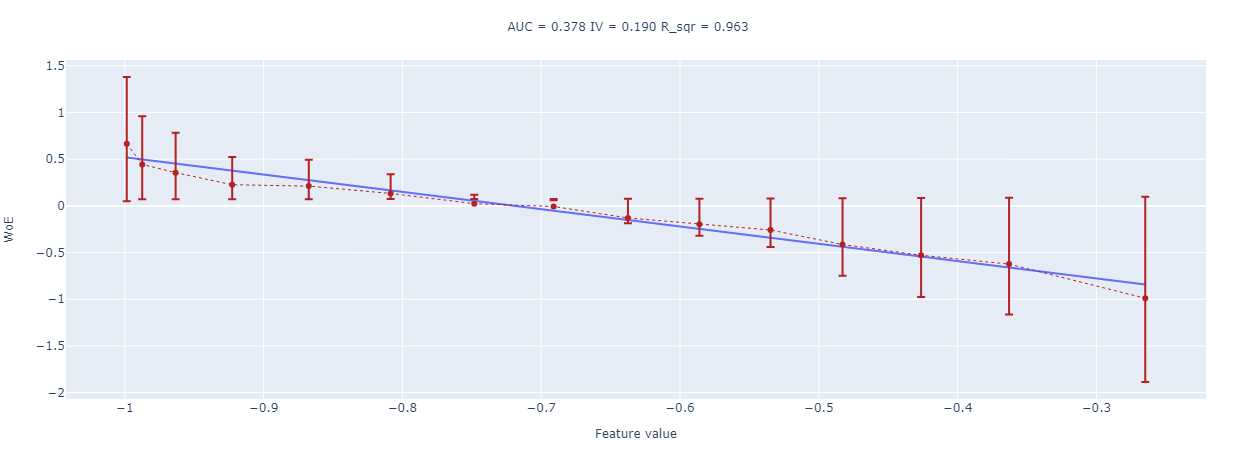

In [85]:
woe_line(values=np.array(-(1/(1 + np.e**(df0.feature_3)))**0.1), target=df0.d4p12, n_buckets=n)

In [86]:
df0.feature_3 = -(1/(1 + np.e**(df0.feature_3)))**0.1

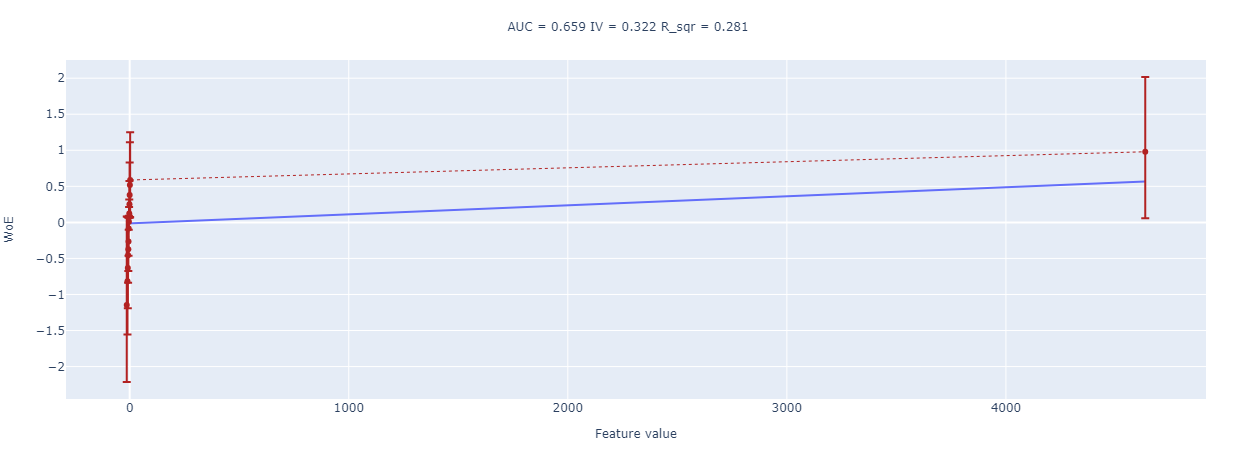

In [87]:
woe_line(values=np.array(df1.feature_3), target=df1.d4p12, n_buckets=n)

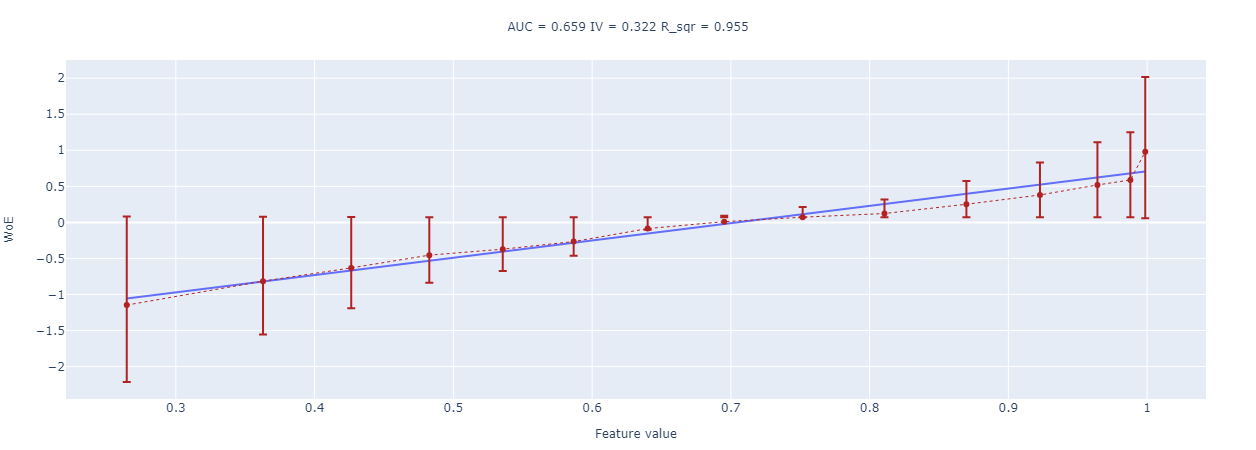

In [88]:
woe_line(values=np.array((1/(1 + np.e**(-df1.feature_3)))**0.1), target=df1.d4p12, n_buckets=n)

In [89]:
df1.feature_3 = (1/(1 + np.e**(-df1.feature_3)))**0.1

### feature_4

In [90]:
# признак неинформативный

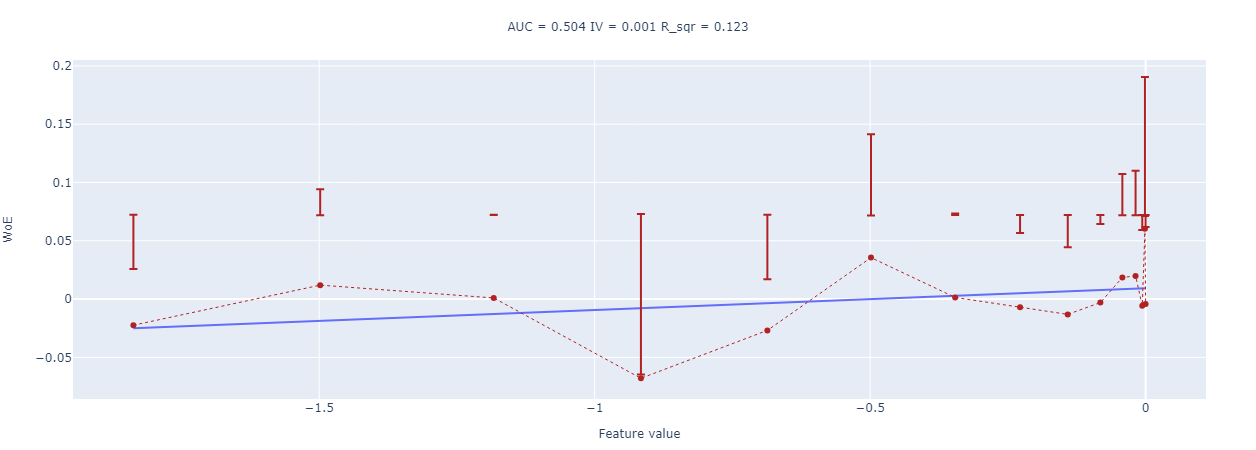

In [91]:
woe_line(values=np.array(df0.feature_4), target=df0.d4p12, n_buckets=n)

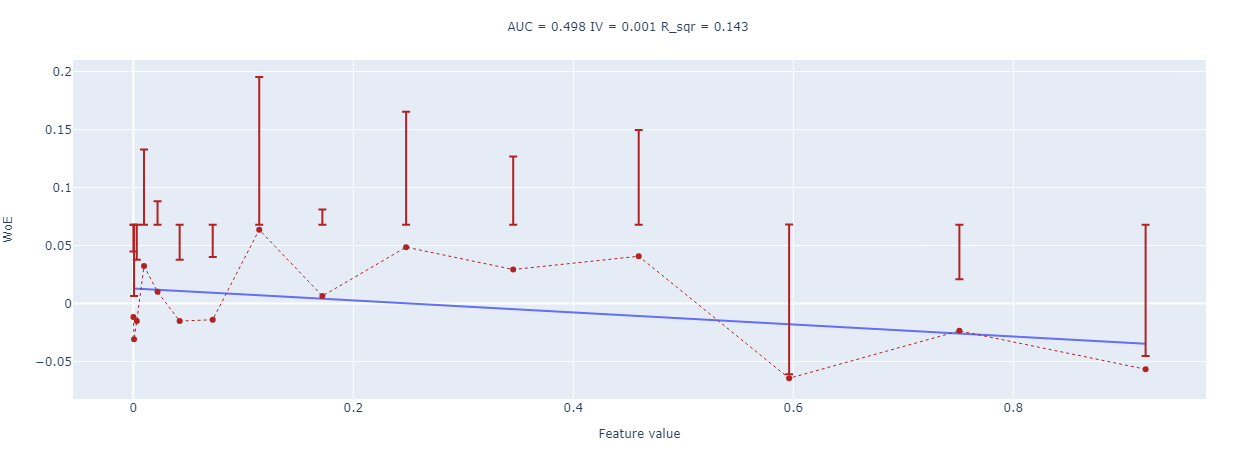

In [92]:
woe_line(values=np.array(df1.feature_4), target=df1.d4p12, n_buckets=n)

In [93]:
df0.drop(['feature_4'], axis=1, inplace=True)
df1.drop(['feature_4'], axis=1, inplace=True)

### feature_5

In [94]:
# признак неинформативный

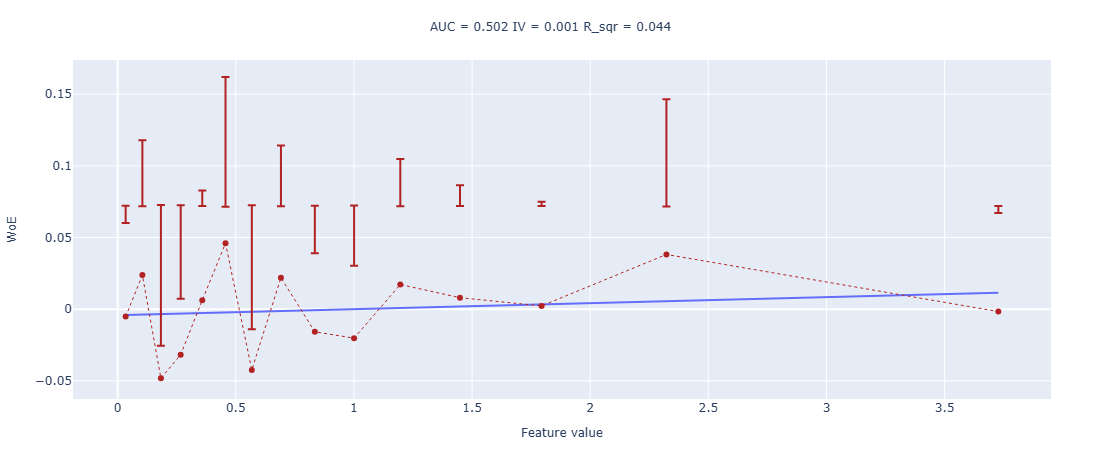

In [95]:
woe_line(values=np.array(df0.feature_5), target=df0.d4p12, n_buckets=n)

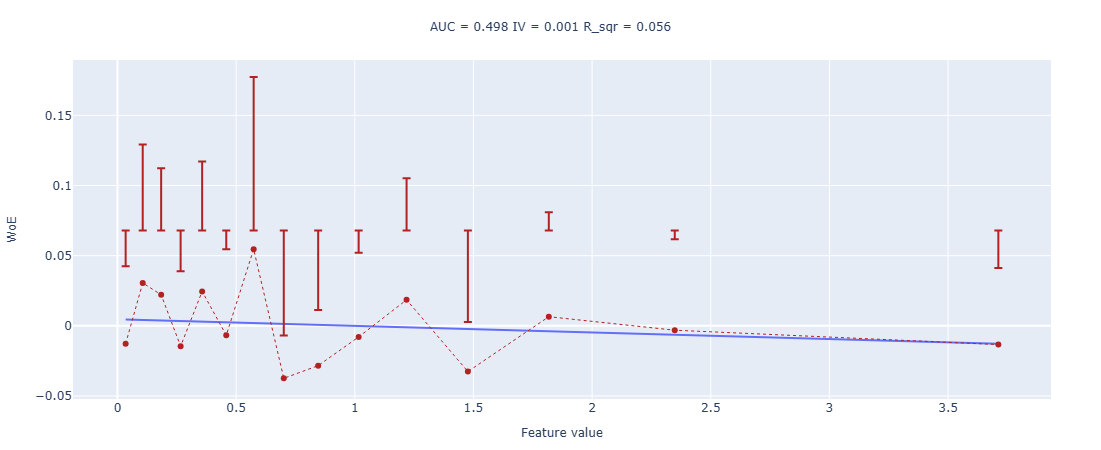

In [96]:
woe_line(values=np.array(df1.feature_5), target=df1.d4p12, n_buckets=n)

In [97]:
df0.drop(['feature_5'], axis=1, inplace=True)
df1.drop(['feature_5'], axis=1, inplace=True)

### feature_8 

In [98]:
# неинформативный

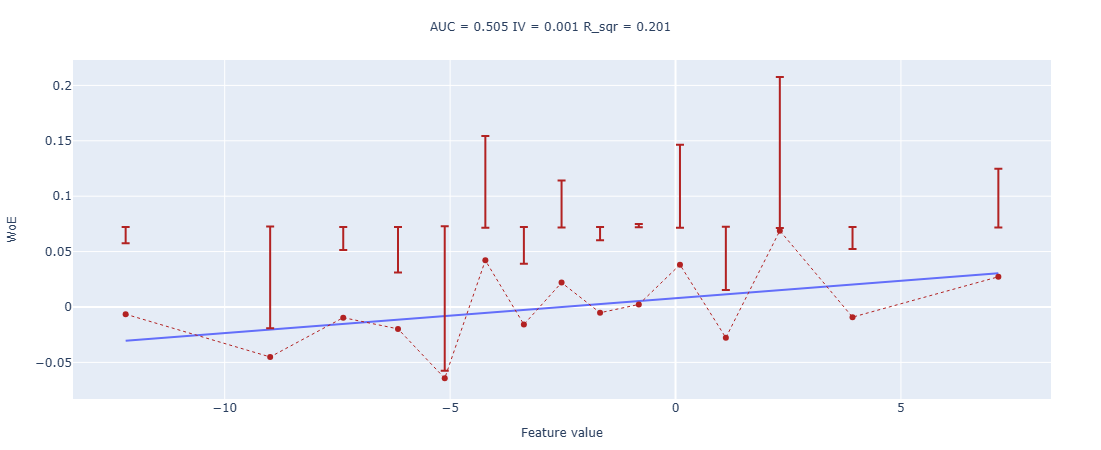

In [99]:
woe_line(values=np.array(df0.feature_8), target=df0.d4p12, n_buckets=n)

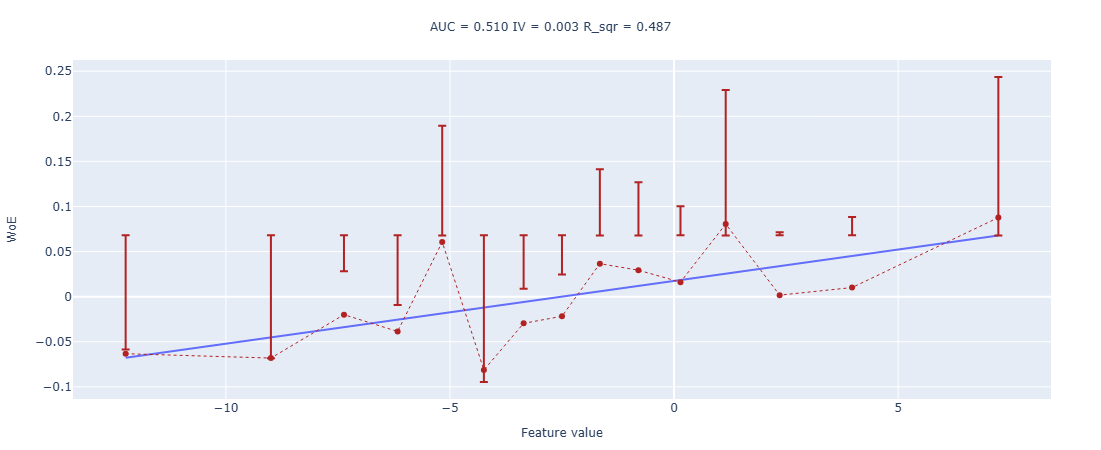

In [100]:
woe_line(values=np.array(df1.feature_8), target=df1.d4p12, n_buckets=n)

In [101]:
df0.drop(['feature_8'], axis=1, inplace=True)
df1.drop(['feature_8'], axis=1, inplace=True)

### feature_9

In [102]:
# неинформативный

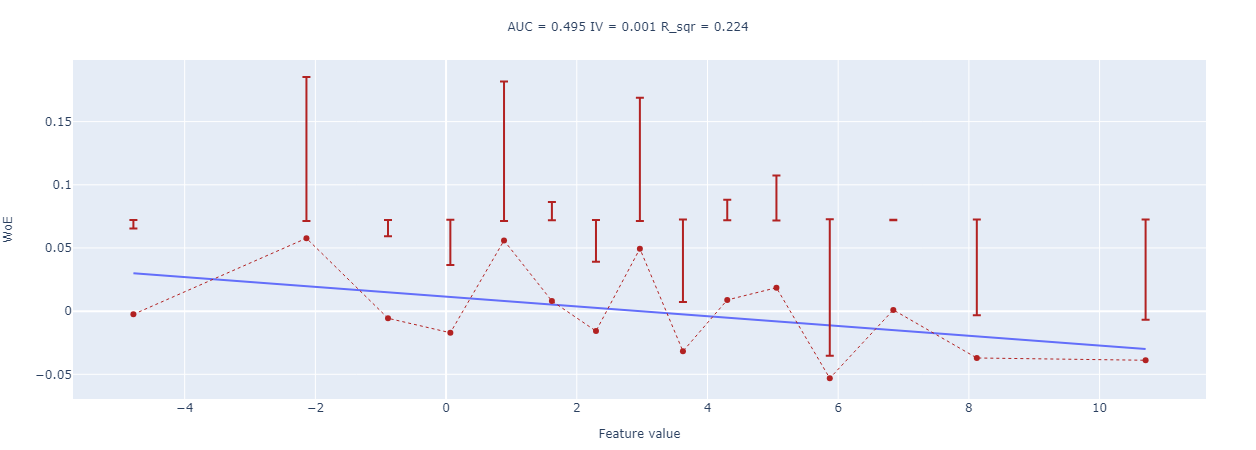

In [103]:
woe_line(values=np.array(df0.feature_9), target=df0.d4p12, n_buckets=n)

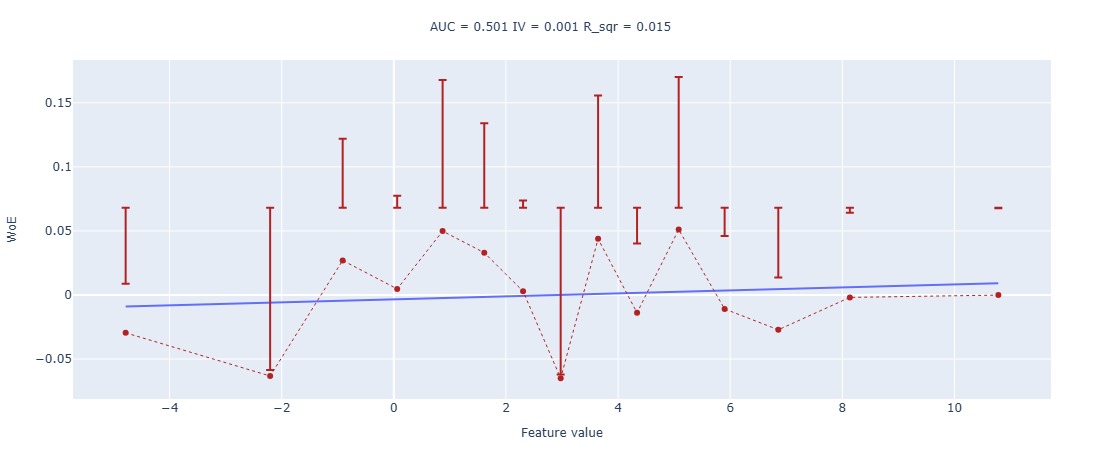

In [104]:
woe_line(values=np.array(df1.feature_9), target=df1.d4p12, n_buckets=n)

In [105]:
df0.drop(['feature_9'], axis=1, inplace=True)
df1.drop(['feature_9'], axis=1, inplace=True)

### feature_10

In [106]:
# неинформативный

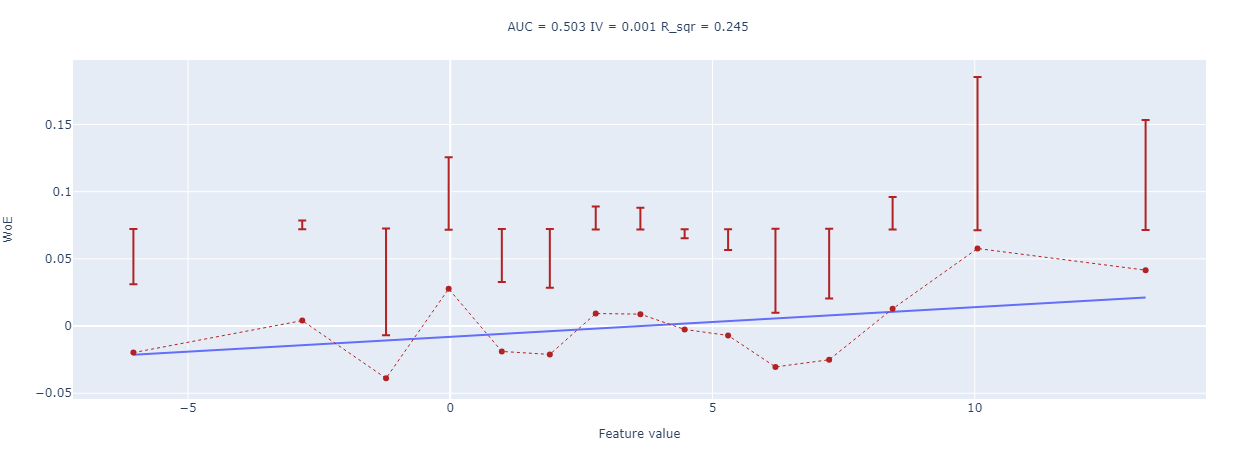

In [107]:
woe_line(values=np.array(df0.feature_10), target=df0.d4p12, n_buckets=n)

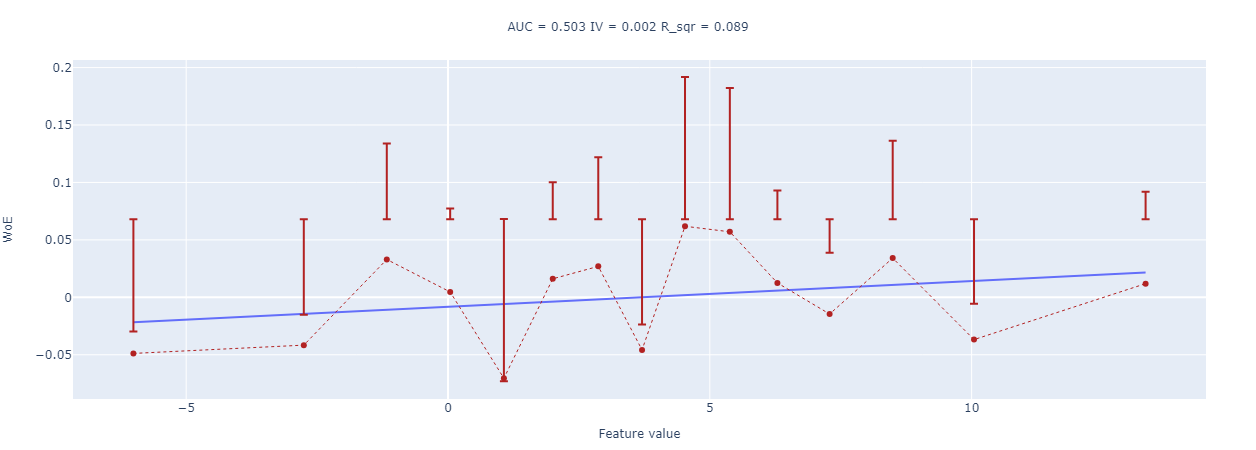

In [108]:
woe_line(values=np.array(df1.feature_10), target=df1.d4p12, n_buckets=n)

In [109]:
df0.drop(['feature_10'], axis=1, inplace=True)
df1.drop(['feature_10'], axis=1, inplace=True)

### feature_11

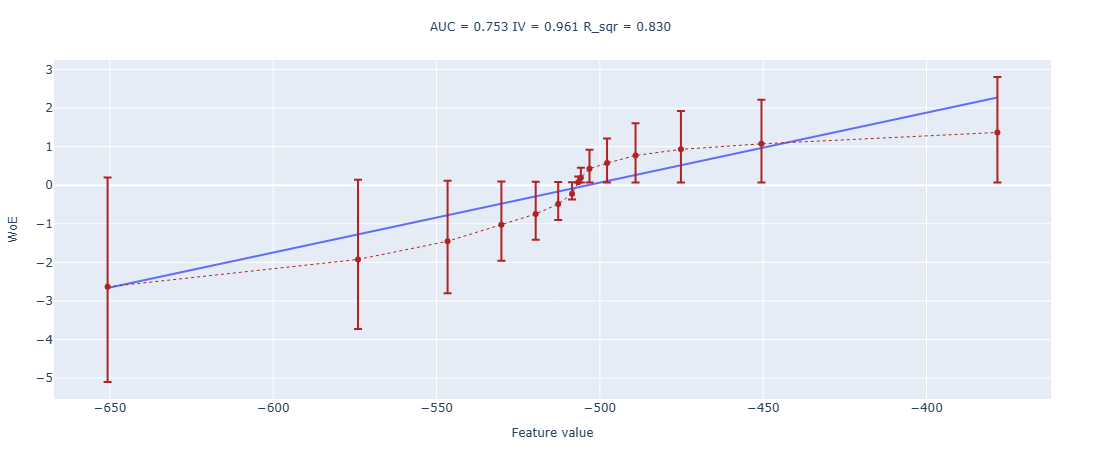

In [110]:
woe_line(values=np.array(df0.feature_11), target=df0.d4p12, n_buckets=n)

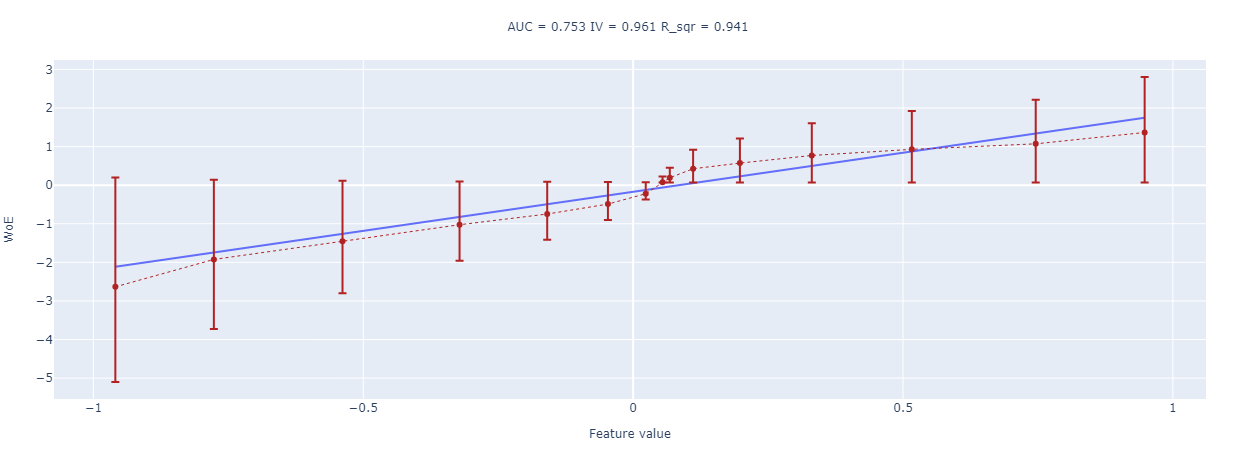

In [111]:
woe_line(values=np.array(np.tanh((df0.feature_11 - np.mean(df0.feature_11))/np.std(df0.feature_11))), target=df0.d4p12, n_buckets=n)

In [112]:
df0.feature_11 = np.tanh((df0.feature_11 - np.mean(df0.feature_11))/np.std(df0.feature_11))

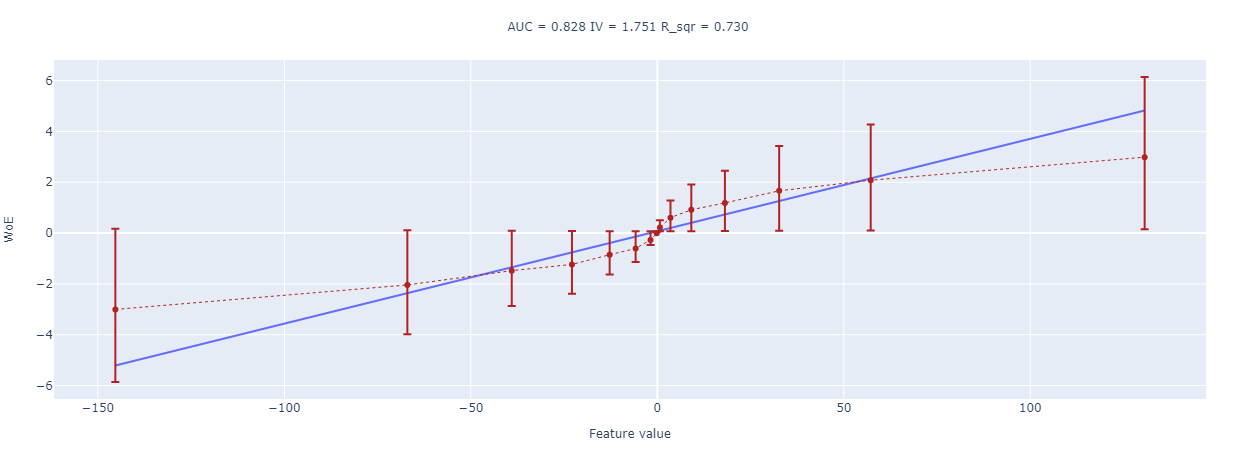

In [113]:
woe_line(values=np.array(df1.feature_11), target=df1.d4p12, n_buckets=n)

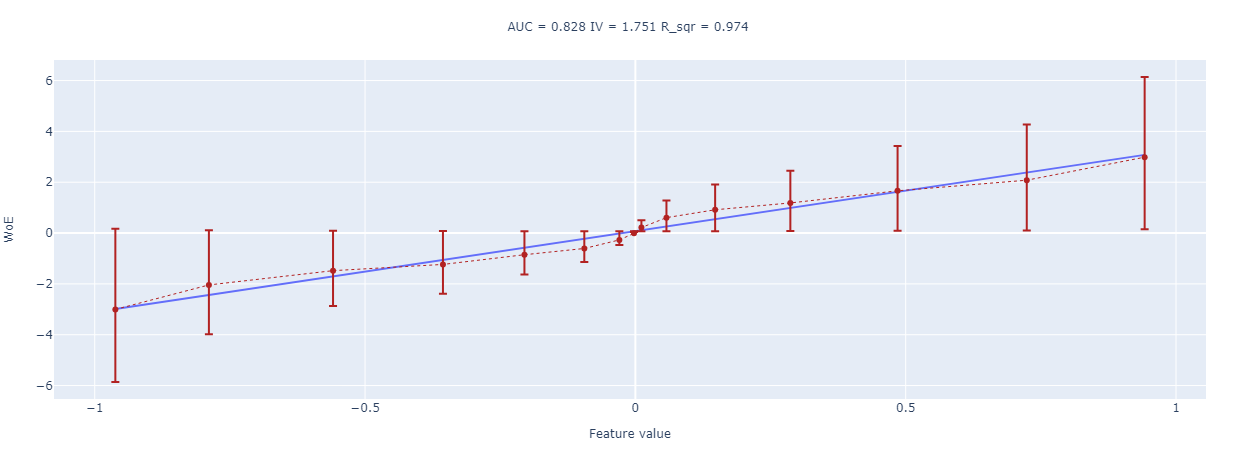

In [114]:
woe_line(values=np.array(np.tanh(df1.feature_11/np.std(df1.feature_11))), target=df1.d4p12, n_buckets=n)

In [115]:
df1.feature_11 = np.tanh(df1.feature_11/np.std(df1.feature_11))

### feature_12

In [116]:
# тут все ок

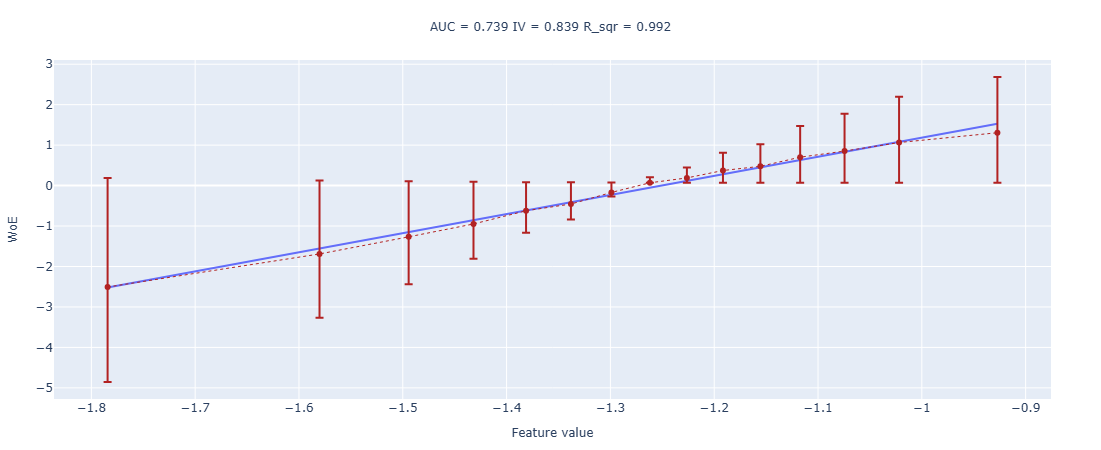

In [117]:
woe_line(values=np.array(df0.feature_12), target=df0.d4p12, n_buckets=n)

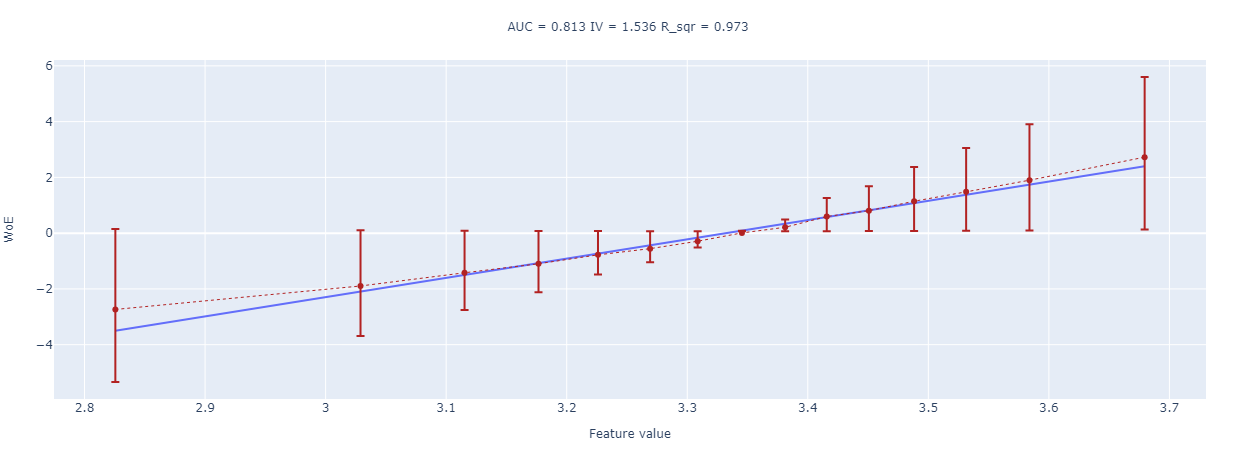

In [118]:
woe_line(values=np.array(df1.feature_12), target=df1.d4p12, n_buckets=n)

### feature_13

In [119]:
# неинформативный

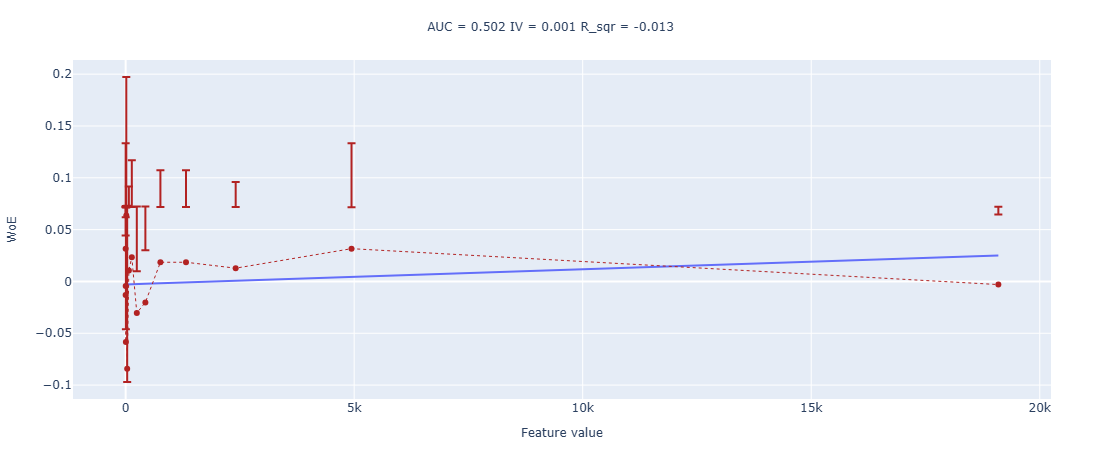

In [120]:
woe_line(values=np.array(df0.feature_13), target=df0.d4p12, n_buckets=n)

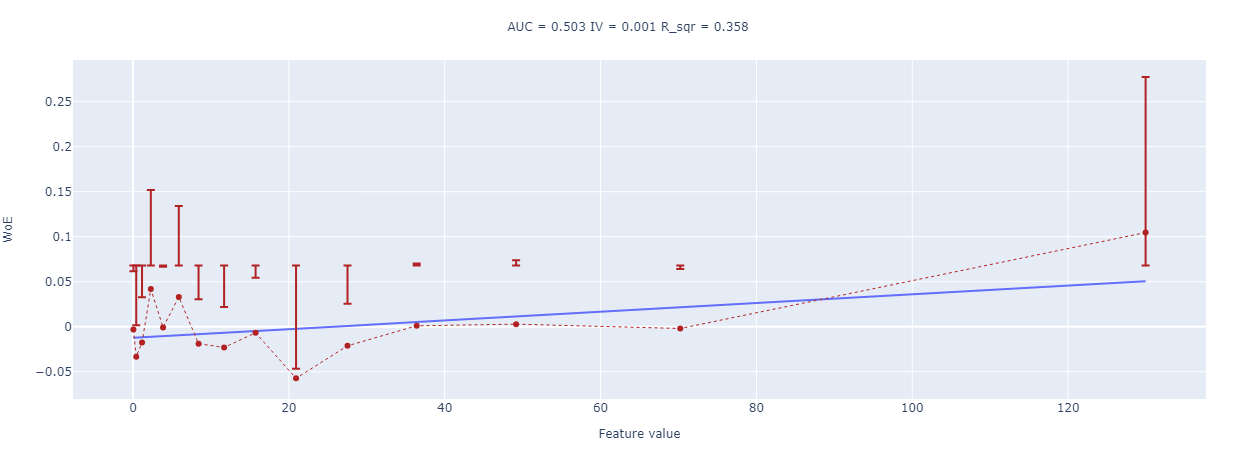

In [121]:
woe_line(values=np.array(df1.feature_13), target=df1.d4p12, n_buckets=n)

In [122]:
df0.drop(['feature_13'], axis=1, inplace=True)
df1.drop(['feature_13'], axis=1, inplace=True)

### feature_14

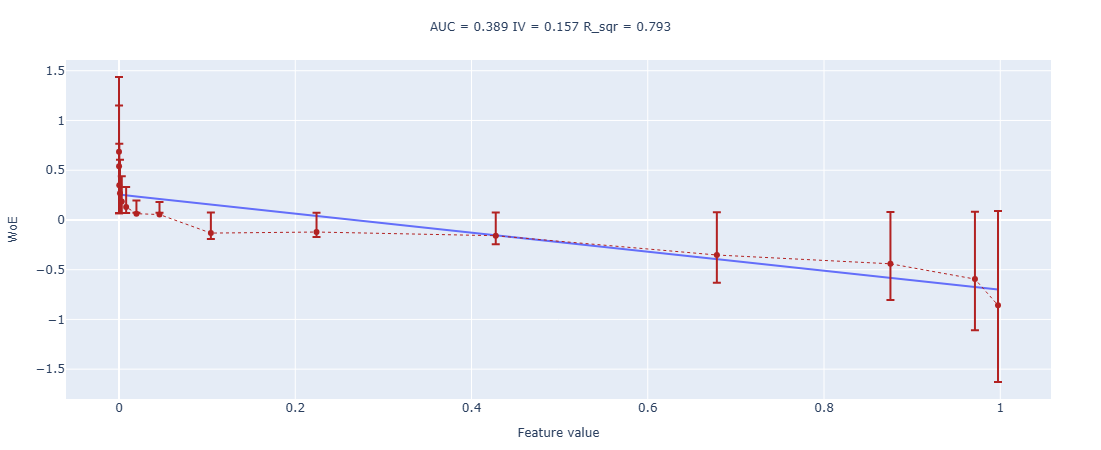

In [123]:
woe_line(values=np.array(df0.feature_14), target=df0.d4p12, n_buckets=n)

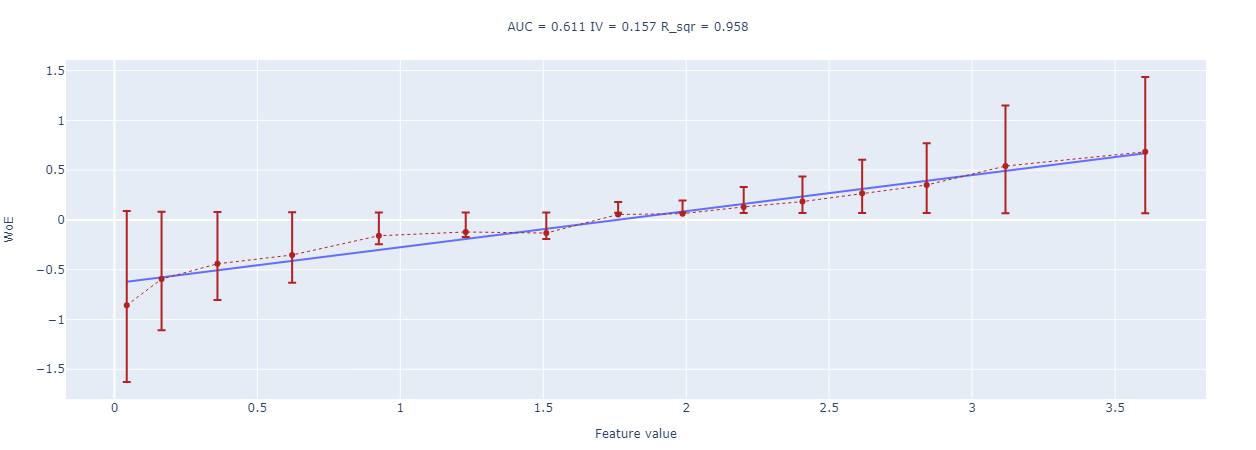

In [124]:
woe_line(values=np.array((-np.log(df0.feature_14))**0.5), target=df0.d4p12, n_buckets=n)

In [125]:
df0.feature_14 = (-np.log(df0.feature_14))**0.5

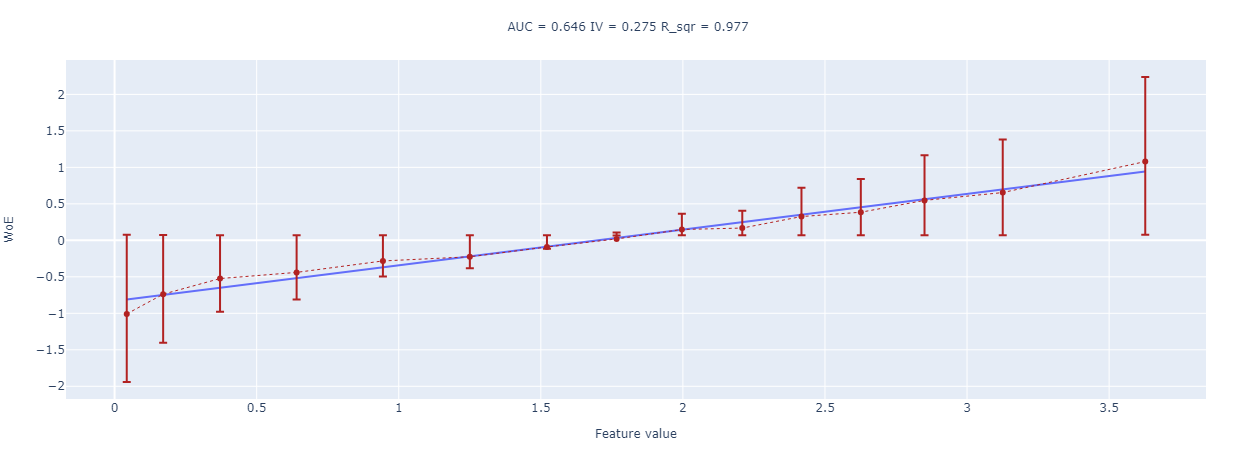

In [126]:
woe_line(values=np.array((-np.log(df1.feature_14))**0.5), target=df1.d4p12, n_buckets=n)

In [127]:
df1.feature_14 = (-np.log(df1.feature_14))**0.5

### Шумовые/слабоинформативные

4, 5, 6, 8, 9, 10, 13

## Финальная модель.

Обучим модели на признаках, которые отобрали и линеаризовали. Пусть $logit_A$ – модель, обученная на сегменте $feature_{15} = A$. $logit_B$ – модель на втором сегменте. Тогда модель на всей выборке будем считать по формуле

$$
logit(x) = \mathbb I \{ feature_{15} = A \} \times logit_A(x) + \mathbb I \{ feature_{15} = B \} \times logit_B(x)
$$

In [128]:
f7_0 = df0.feature_7.reset_index(drop=True)
y0 = df0.d4p12.reset_index(drop=True)
f7_1 = df1.feature_7.reset_index(drop=True)
y1 = df1.d4p12.reset_index(drop=True)
df0.drop(['feature_7', 'd4p12'], axis=1, inplace=True)
df1.drop(['feature_7', 'd4p12'], axis=1, inplace=True)
cols = df0.columns

In [129]:
# scaler0 = MinMaxScaler()
# scaler1 = MinMaxScaler()
scaler0 = StandardScaler()
scaler1 = StandardScaler()

In [130]:
sc0 = scaler0.fit_transform(df0)
sc0 = pd.DataFrame(data=sc0, columns=cols)
sc0['feature_7'] = f7_0
sc1 = scaler1.fit_transform(df1)
sc1 = pd.DataFrame(data=sc1, columns=cols)
sc1['feature_7'] = f7_1

In [131]:
X_train0, X_test0, y_train0, y_test0 = train_test_split(sc0, y0, test_size=0.2, random_state=0)
X_train1, X_test1, y_train1, y_test1 = train_test_split(sc1, y1, test_size=0.2, random_state=0)

In [132]:
lr0 = LogisticRegression()
lr1 = LogisticRegression()

lr0.fit(X_train0, y_train0)
lr1.fit(X_train1, y_train1)

LogisticRegression()

In [133]:
y_pred0 = lr0.predict(X_test0)
y_pred_train0 = lr0.predict(X_train0)

In [134]:
y_pred1 = lr1.predict(X_test1)
y_pred_train1 = lr1.predict(X_train1)

In [135]:
y_pred = np.concatenate((y_pred0, y_pred1))
y_true = np.concatenate((y_test0, y_test1))

y_pred_train = np.concatenate((y_pred_train0, y_pred_train1))
y_true_train = np.concatenate((y_train0, y_train1))

In [136]:
train_proba = np.concatenate((lr0.predict_proba(X_train0)[:,1], lr1.predict_proba(X_train1)[:,1]))
test_proba = np.concatenate((lr0.predict_proba(X_test0)[:,1], lr1.predict_proba(X_test1)[:,1]))

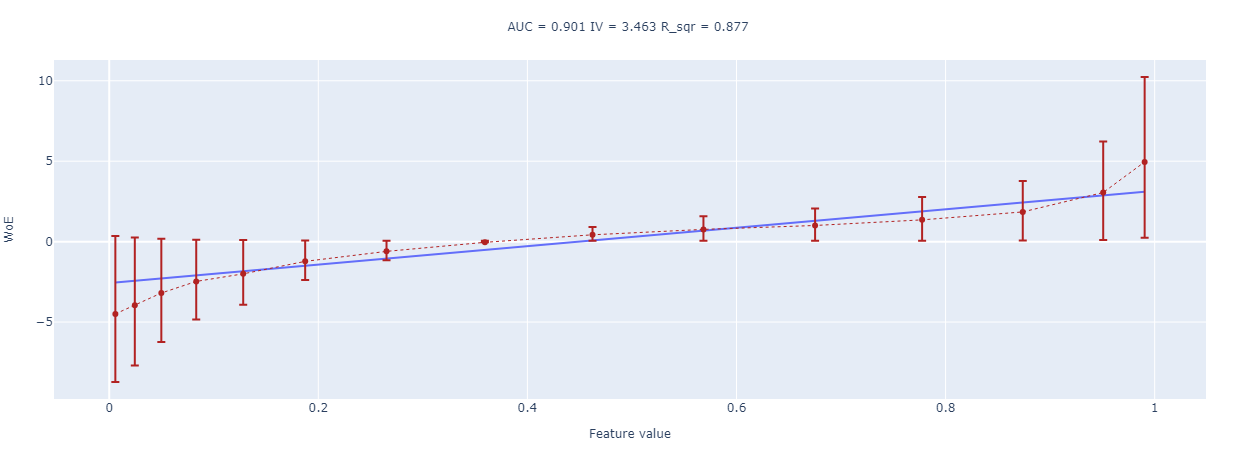

In [137]:
woe_line(values=train_proba, target=y_true_train, n_buckets=n)

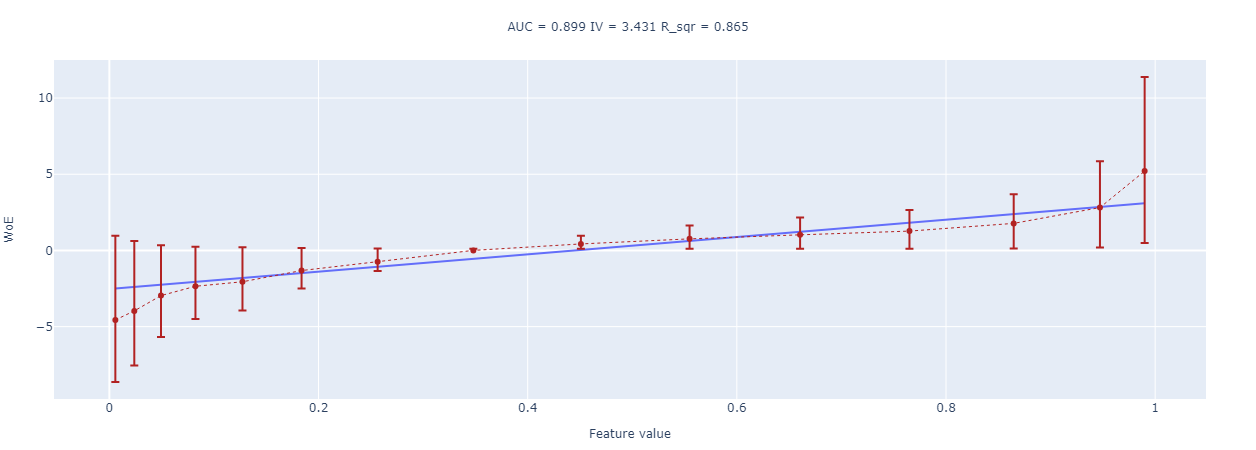

In [138]:
woe_line(values=test_proba, target=y_true, n_buckets=n)

In [139]:
print(f'train auc: {roc_auc_score(y_true_train, train_proba)}')
print(f'test auc: {roc_auc_score(y_true, test_proba)}')

train auc: 0.9010898296574191
test auc: 0.8990858533533943


In [140]:
print(f'IV train: {calc_iv(train_proba, y_true_train, calc_buckets(train_proba, n))}')
print(f'IV test: {calc_iv(test_proba, y_true, calc_buckets(test_proba, n))}')

IV train: 3.4627705823281385
IV test: 3.43054833134875


# Формулы и преобразования

## **1**

Для определения $WoE$ мы пользовались Теоремой Байеса. Применим ее и **покажем, что верно равенство**:

$$
\ln \left(  \frac{P(x_i|y=1)}{P(x_i|y=0)} \right) = ... = \ln \left( \frac{P(y=1|x_i)}{P(y=0|x_i)} \right) - \ln \left( \frac{P(y=1)}{P(y=0)} \right)
$$

$
\ln \left(  \frac{P(x_i|y=1)}{P(x_i|y=0)} \right) = \ln \left(  \frac{P(y=1|x_i) P(x_i) P(y=0)}{P(y=1) P(y=0|x_i) P(x_i)} \right) = \ln \left(  \frac{P(y=1|x_i) P(y=0)}{P(y=0|x_i) P(y=1)} \right) = \ln \left(  \frac{\frac{P(y=1|x_i)}{P(y=0|x_i)}}{\frac{P(y=1)}{P(y=0)}} \right) = \ln \left( \frac{P(y=1|x_i)}{P(y=0|x_i)} \right) - \ln \left( \frac{P(y=1)}{P(y=0)} \right)
$

## **2**

Известно:

$WoE$ можно посчитать так:
$WoE_i(x_i) = \ln \Big ( \frac{B_i}{G_i} \Big ) - \ln \Big ( \frac{B}{G} \Big ) $

Частота выхода в дефолт:  $badrate = \frac{B}{B+G}; \quad badrate_i = \frac{B_i}{B_i+G_i}$

$
\sigma (x) = \frac{1}{1+e^{-x}}; \quad logit(x) = \ln \left( \frac{x}{1-x} \right)
$

**Покажем, что**
$WoE_i(x_i) = logit(badrate_i) - logit(badrate)$

logit($\frac{b_i}{b_i + g_i}$) - logit($\frac{b}{b + g}$) =  ln($\frac{\frac{b_i}{b_i + g_i}}{1 - \frac{b_i}{b_i + g_i}}$) - ln($\frac{\frac{b}{b + g}}{1 - \frac{b}{b + g}}$) = ln($\frac{\frac{b_i}{b_i + g_i}}{\frac{g_i}{b_i + g_i}}$) - ln($\frac{\frac{b}{b + g}}{\frac{g}{b + g}}$) = ln($\frac{b_i}{g_i}$) - ln($\frac{b}{g}$) = $WoE_i(x_i)$

## **3**

Пусть даны два дискретных распределения: 

$B=(b_1, ..., b_n)$ и $G=(g_1, ..., g_n)$.

KL-дивергенция для дискретных распределений

$$D_{KL}(B||G) = \sum_{j=1}^{n} b_j \ln \left( \frac{b_j}{g_j} \right)$$


Пусть $x$ - дикретный признак, принимающий значения $x_1,...,x_n$.
Известно определение IV через KL-дивергенцию:

$$
IV_x = D_{KL}(B_x||G_x)+D_{KL}(G_x||B_x)
$$
где 

$$
B_x (x_i) = P(x=x_i|y=1) = b_i; \quad G_x (x_i) = P(x=x_i|y=0) = g_i
$$

**Выразим $IV$ через $WoE$**





$IV_x = D_{KL}(B_x||G_x)+D_{KL}(G_x||B_x) = \sum_{j=1}^{n} b_j \ln \left( \frac{b_j}{g_j} \right) + \sum_{j=1}^{n} g_j \ln \left( \frac{g_j}{b_j} \right) = \sum_{j=1}^{n} (b_j \ln \left( \frac{b_j}{g_j} \right) + g_j \ln \left( \frac{g_j}{b_j} \right)) = $
$\sum_{j=1}^{n} (b_j \ln \left( \frac{b_j}{g_j} \right) - g_j \ln \left( \frac{b_j}{g_j} \right)) = \sum_{j=1}^{n} \ln \left( \frac{b_j}{g_j} \right)(b_j - g_j) = $
$\sum_{j=1}^{n} [p(x=x_j|y=1) - p(x=x_j|y=0)] \ln \frac{p(x=x_j|y=1)}{p(x=x_j|y=0)} = \sum_{j=1}^{n} (\frac{b_j}{B} - \frac{g_j}{G}) WOE_j$ 